<a href="https://colab.research.google.com/github/Boon-Yang/Machine-Learning-for-Defect-Detection-In-Additive-Manufacturing/blob/master/Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mounting Notebook to G. Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import scipy.io as io
import os 
import matplotlib.pyplot as plt
import pandas as pd
os.chdir('drive/My Drive/FYP MAT Data')

## Import Data


### Get data

In [3]:
import matplotlib.pyplot as plt
import pickle

In [5]:
import numpy as np
import h5py

f = h5py.File('build1_layer_200.mat','r')

# all the variables in the mat file
print(list(f))

['#refs#', '#subsystem#', 'cam1aligned', 'cam2aligned', 'end_frame', 'frame_time', 'is_frame_range_clipped', 'positionimgs', 'power', 'stats', 'temperatureimgs', 'x_true_pos', 'y_true_pos']


In [ ]:
# get image from cam1aligned
data = f.get('temperatureimgs')
data = np.array(data)

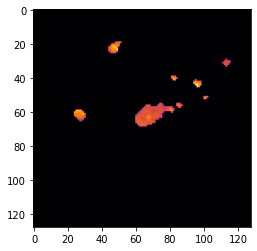

In [9]:
plt.imshow(data[5000], cmap='inferno')
plt.show()

In [ ]:
# get frame time
frame_time = f.get('frame_time')
frame_time = np.array(frame_time)

In [ ]:
# import pickle
# with open('cam1aligned(build_layer_200)', 'wb') as file:
#     d = pickle.dump(data, file, protocol=4)

### Functions

In [10]:
def cut_image(img, cutoff=0.4):
  '''
  Cut the image into top, bottom, left and right subregions. The size of each subregion is determined by the cutoff parameter
  '''
  
  y0 = 0
  y1 = int(img.shape[0]*cutoff)
  y2 = int(img.shape[0]*(1-cutoff))
  y3 = img.shape[0]
  
  x0 = 0
  x1 = int(img.shape[1]*cutoff)
  x2 = int(img.shape[1]*(1-cutoff))
  x3 = img.shape[1]
  
  top = img[y0:y1, :]
  bottom = img[y2:y3, :]
  left = img[y1:y2, x0:x1]
  right = img[y1:y2, x2:x3]
  
  return top, bottom, left, right
  

In [61]:
# os.chdir('drive/My Drive/FYP MAT Data')
# Change this to True when computing the features for the first time
make_df = False

if make_df == True:
  std_dev = np.array([np.std(data[i]) for i in range(data.shape[0])])

  # get proportion of pixels with value greater than zero(293)
  zeroFunc = lambda x: x>293
  nonZeroProportion = np.array([zeroFunc(data[i]).mean() for i in range(data.shape[0])])
  
  mean_of_slices = lambda x: x.mean()
  slices_mean = [sum(list(map(mean_of_slices, cut_image(data[i])))) for i in range(data.shape[0])]

  features_df = pd.DataFrame(std_dev, columns=['std_dev'])
  features_df['nonZeroProp'] = nonZeroProportion
  features_df['subRegionMean'] = np.array(slices_mean)
  
  
  # Dump the features_df and save it locally into our current Folder
  with open('features_df', 'wb') as file:
    pickle.dump(features_df, file, protocol=4)
  features_df.head() 
  
else:
  with open(r"features_df", "rb") as input_file:
    features_df = pickle.load(input_file)

In [62]:
features_df.head()

,std_dev,nonZeroProp,subRegionMean
0,0.0,0.0,1172.0
1,0.0,0.0,1172.0
2,0.0,0.0,1172.0
3,0.0,0.0,1172.0
4,0.0,0.0,1172.0


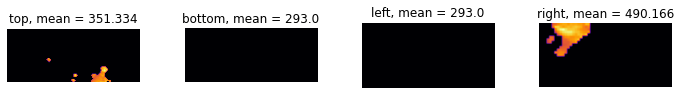

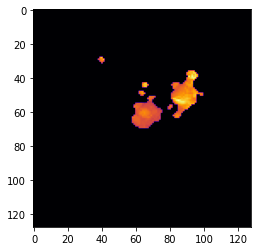

In [63]:
slices = cut_image(data[13000])

fig, axes = plt.subplots(nrows = 1, ncols= len(slices), figsize=(10, 5))

axes = axes.flatten()

plt.tight_layout()
directions = ['top', 'bottom', 'left', 'right']
for idx, ax in enumerate(axes):
  
  ax.imshow(slices[idx], cmap='inferno')
  
  ax.set_axis_off()
  
  ax.set_title(directions[idx] + ', mean = {}'.format(round(slices[idx].mean(), 3)))
plt.show()
plt.imshow(data[13000], cmap='inferno')
plt.show()

In [64]:
def get_val_between(col, val_range=[40, 60], df=features_df):
  '''
  val_range, a list: [upperBound, lowerBoud]
  df: dataFrame, default: featuresDataFrame
  col: the df's column of interest, default='std_dev'
  Return the indices of images which has std dev or any features in between the bounds.
  
  '''
  lower_bound = val_range[0]
  upper_bound = val_range[1]
  condition = df[col].apply(lambda x: lower_bound <= x < upper_bound)

  return df[condition == True].index.values

In [65]:
def computeZScore(df):
  '''
  Compute the z-score for a ll the values in a df. Return the z score dataFrame. 
  '''
  temp = pd.DataFrame(df.copy())
  for col in temp.columns.values:
    miu = df[col].mean()
    sigma = df[col].std()
    temp[col] = temp[col].apply(lambda x: (x - miu)/sigma)
    
  return temp

In [66]:
def min_max_norm(df):
  '''
  Normalize a given dataFrame. Return the normalized dataFrame. 
  '''
  temp = pd.DataFrame(df.copy())
  for col in temp.columns.values:
    mini = df[col].min()
    maxi = df[col].max()
    temp[col] = temp[col].apply(lambda x: (x - mini)/(maxi - mini) if x != maxi else 1)
    
  return temp

In [78]:
def disp_images_within_bound(lower_bound, higher_bound, col, number_of_images, df=features_df, data=data):
  
  image_index = get_val_between(val_range=[lower_bound, higher_bound], col=col)
  print('The lowerBound for {} is '.format(col) + str(lower_bound))
  print('The upperBound for {} is '.format(col) + str(higher_bound))  
  np.random.seed(seed=42)
  fig, axes = plt.subplots(nrows=int(number_of_images/5), ncols=5, figsize=(30, 25))
  displayed_imageId = []
  axes = axes.flatten()
  plt.tight_layout()

  for idx in range(number_of_images):
    # Generate random image Id
    i = np.random.randint(low=0, high=len(image_index))
    imageId = image_index[i]

    # Printing the images
    ax = axes[idx]
    ax.imshow(data[imageId], cmap='inferno')

    ax.set_axis_off()
    ax.set_title('Image_id = {}, \n nonZeroProp = {}%, std_dev = {}, subRegionMean = {}'.format(imageId, round(features_df['nonZeroProp'].iloc[imageId]*100, 3), round(features_df['std_dev'].iloc[imageId], 2), round(features_df['subRegionMean'].iloc[imageId], 2)))
    displayed_imageId.append(imageId)
  return sorted(displayed_imageId)

### Exploratory Data Analysis

We extracted 3 features from each of the image, namely:
1. Std dev:- Standard deviation of all the pixels in an image
2. nonZeroProp:- Proportion of pixels with value greater than zero
3. subRegionMean:- The sum of average of pixel intensity from top, bottom, left and right sub-regions of each image

In [68]:
features_df.tail()

,std_dev,nonZeroProp,subRegionMean
349264,303.084237,0.012146,1178.671415
349265,315.958790,0.012146,1178.093597
349266,318.146920,0.012085,1180.015012
349267,306.248470,0.011902,1179.112745
349268,319.948306,0.012512,1179.282475


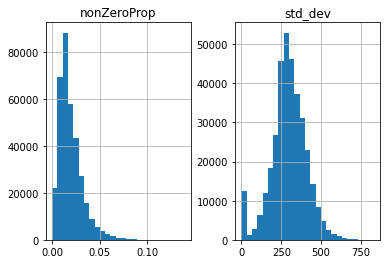

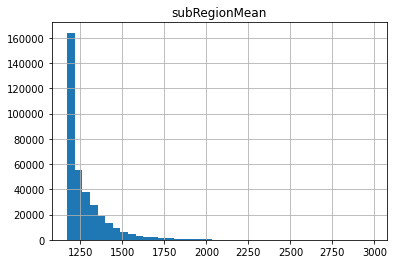

In [69]:
features_df[['nonZeroProp', 'std_dev']].hist(bins= 25)

plt.figure()
features_df['subRegionMean'].hist(bins=40)
plt.title('subRegionMean')
plt.show()

### Printing out several images
By putting bounds on the 
1. nonZeroProp
2. stdDev features
3. subregionMean

### non Zero Prop

The nonZeroProp distribution has a long tail. Let's investigate what's happening at the tail of the distribution.

The lowerBound for nonZeroProp is 0.1
The upperBound for nonZeroProp is 0.15


[25420,
 25420,
 25421,
 25433,
 80656,
 80656,
 80657,
 80659,
 80665,
 96032,
 97332,
 97346,
 97347,
 97354,
 97355,
 97358,
 97366,
 97370,
 97370,
 97371]

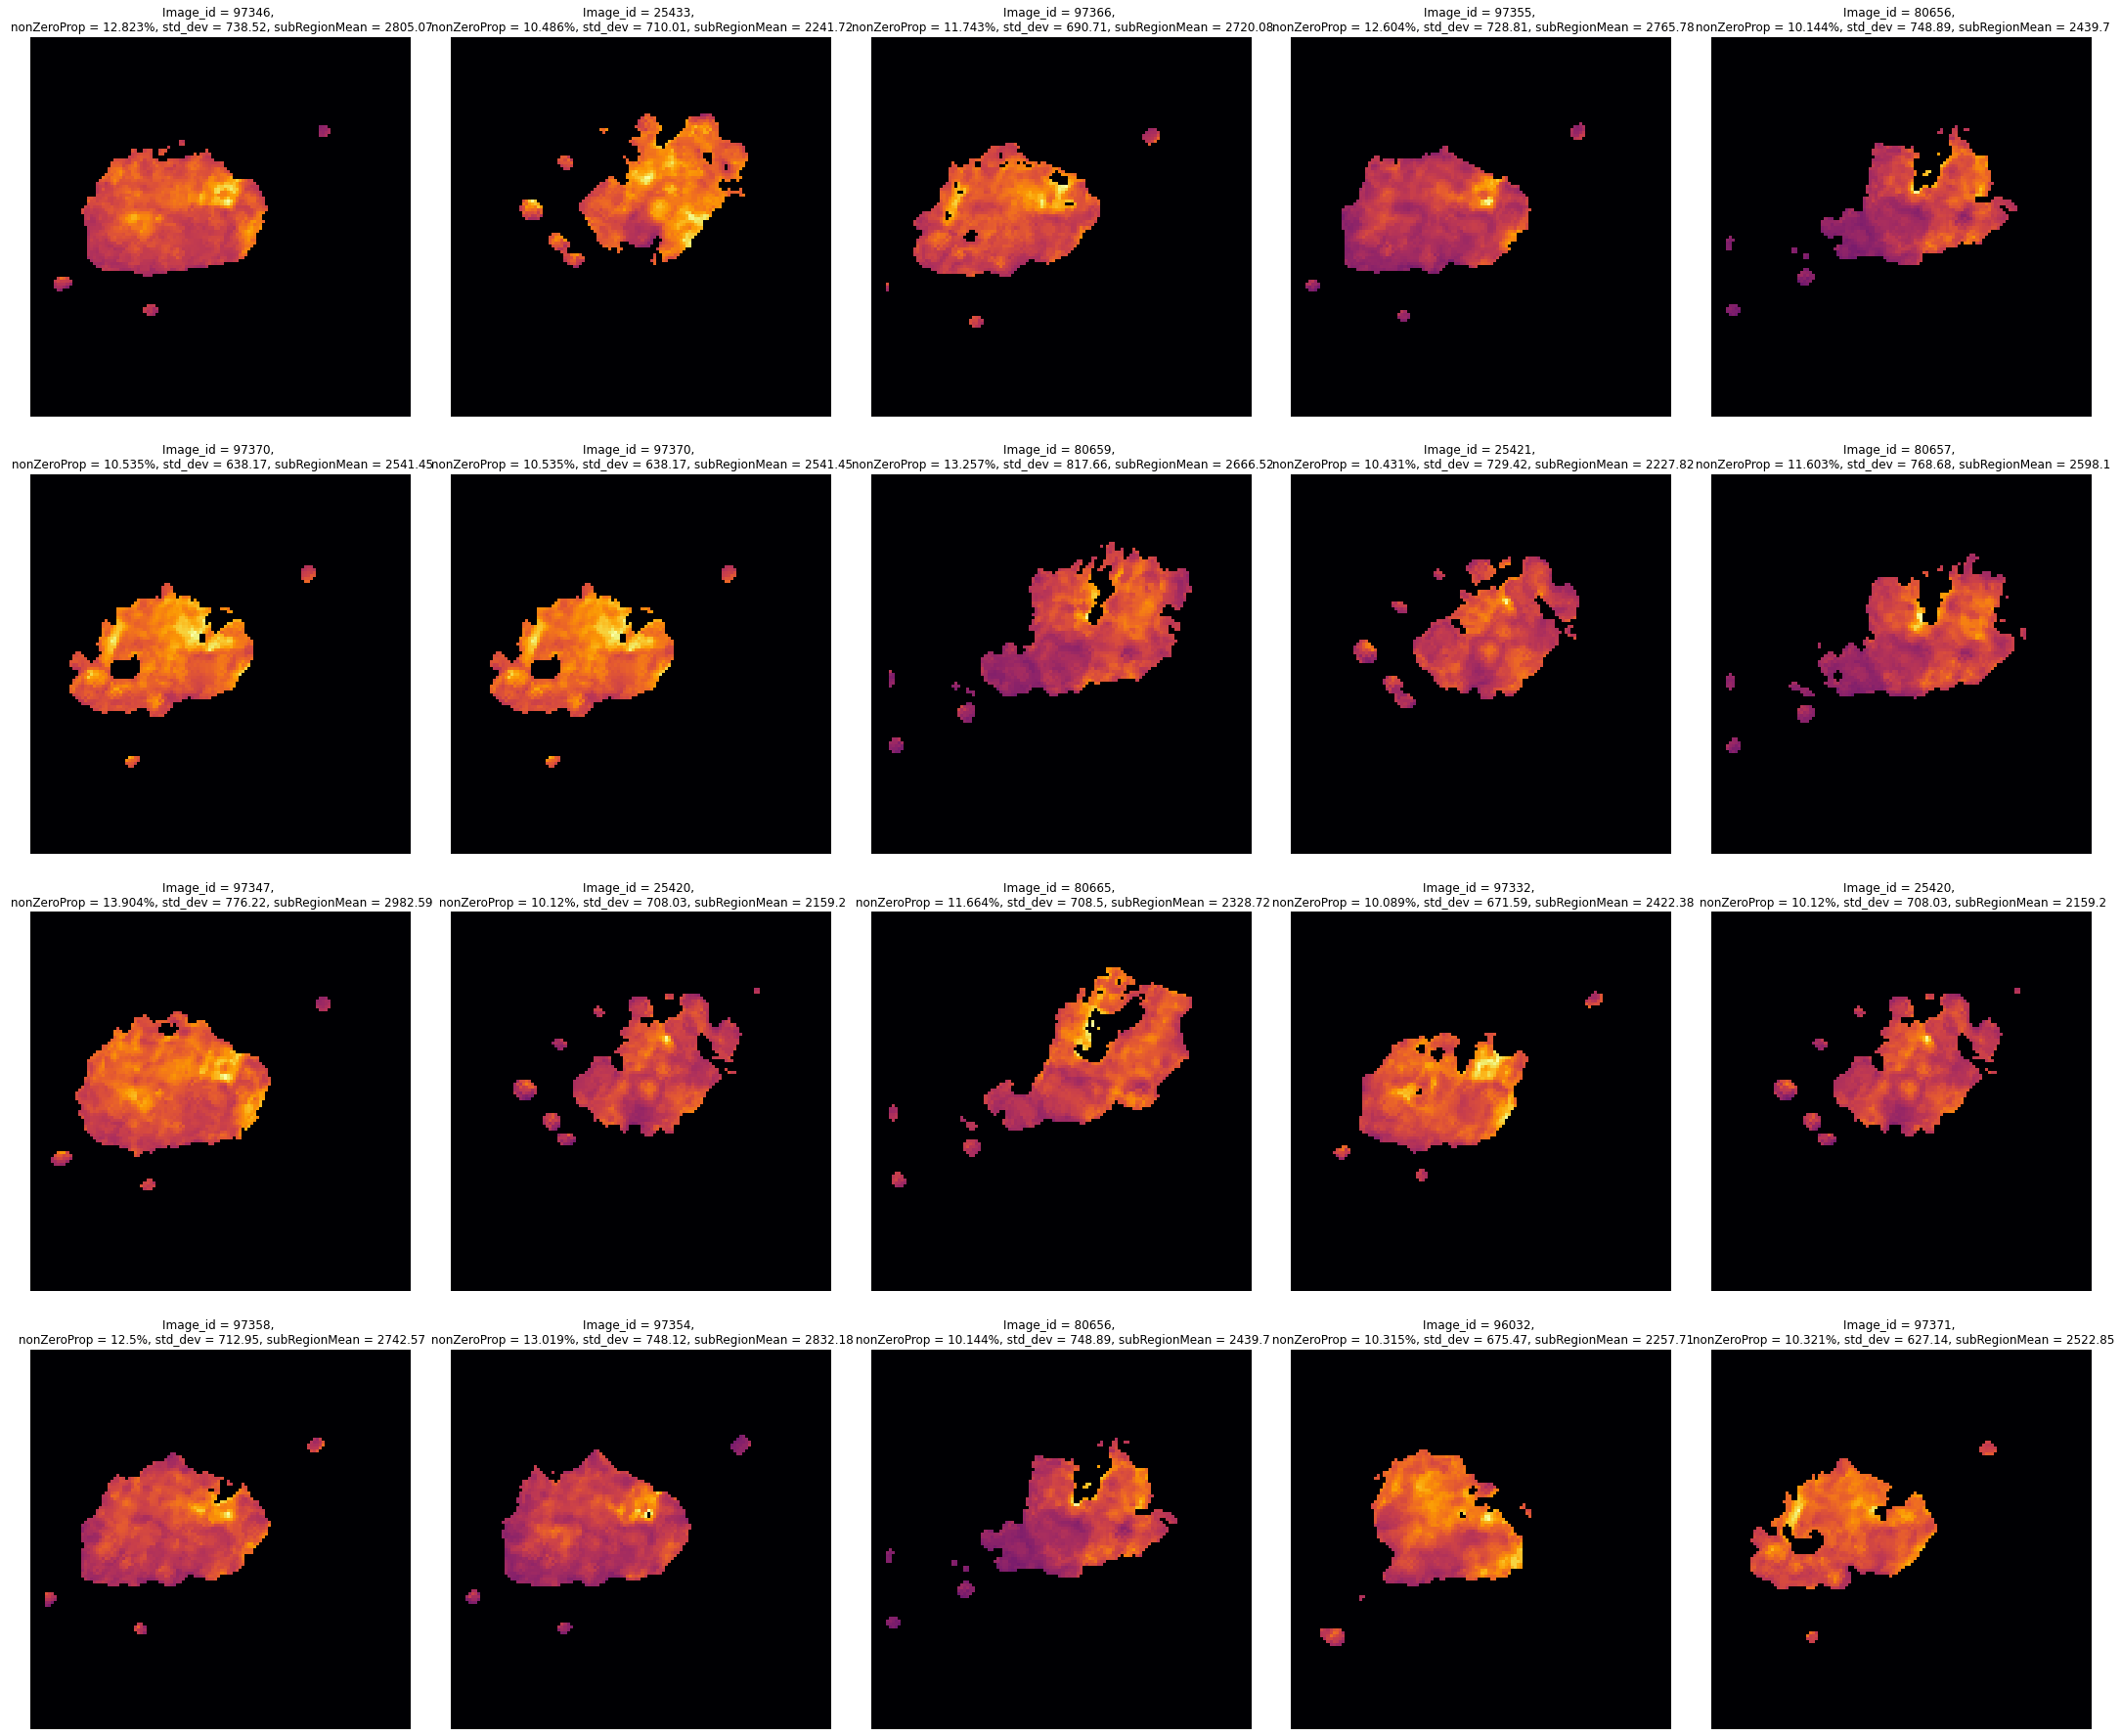

In [79]:
# The long tail, the extremities 
col = 'nonZeroProp'

# Set the absolute bound(not the percentile)
lowerBound = 0.10
upperBound = 0.15

# DISPLAY IMAGES
disp_images_within_bound(lower_bound=lowerBound, higher_bound=upperBound, col=col, number_of_images=20, df=features_df, data=data)   

Then let's look into the middle part

The lowerBound for nonZeroProp is 0.05
The upperBound for nonZeroProp is 0.1


[1629,
 2413,
 2519,
 5359,
 21989,
 80714,
 103925,
 165142,
 167415,
 168732,
 169247,
 170757,
 172913,
 174249,
 174405,
 177194,
 177393,
 179566,
 180145,
 182088]

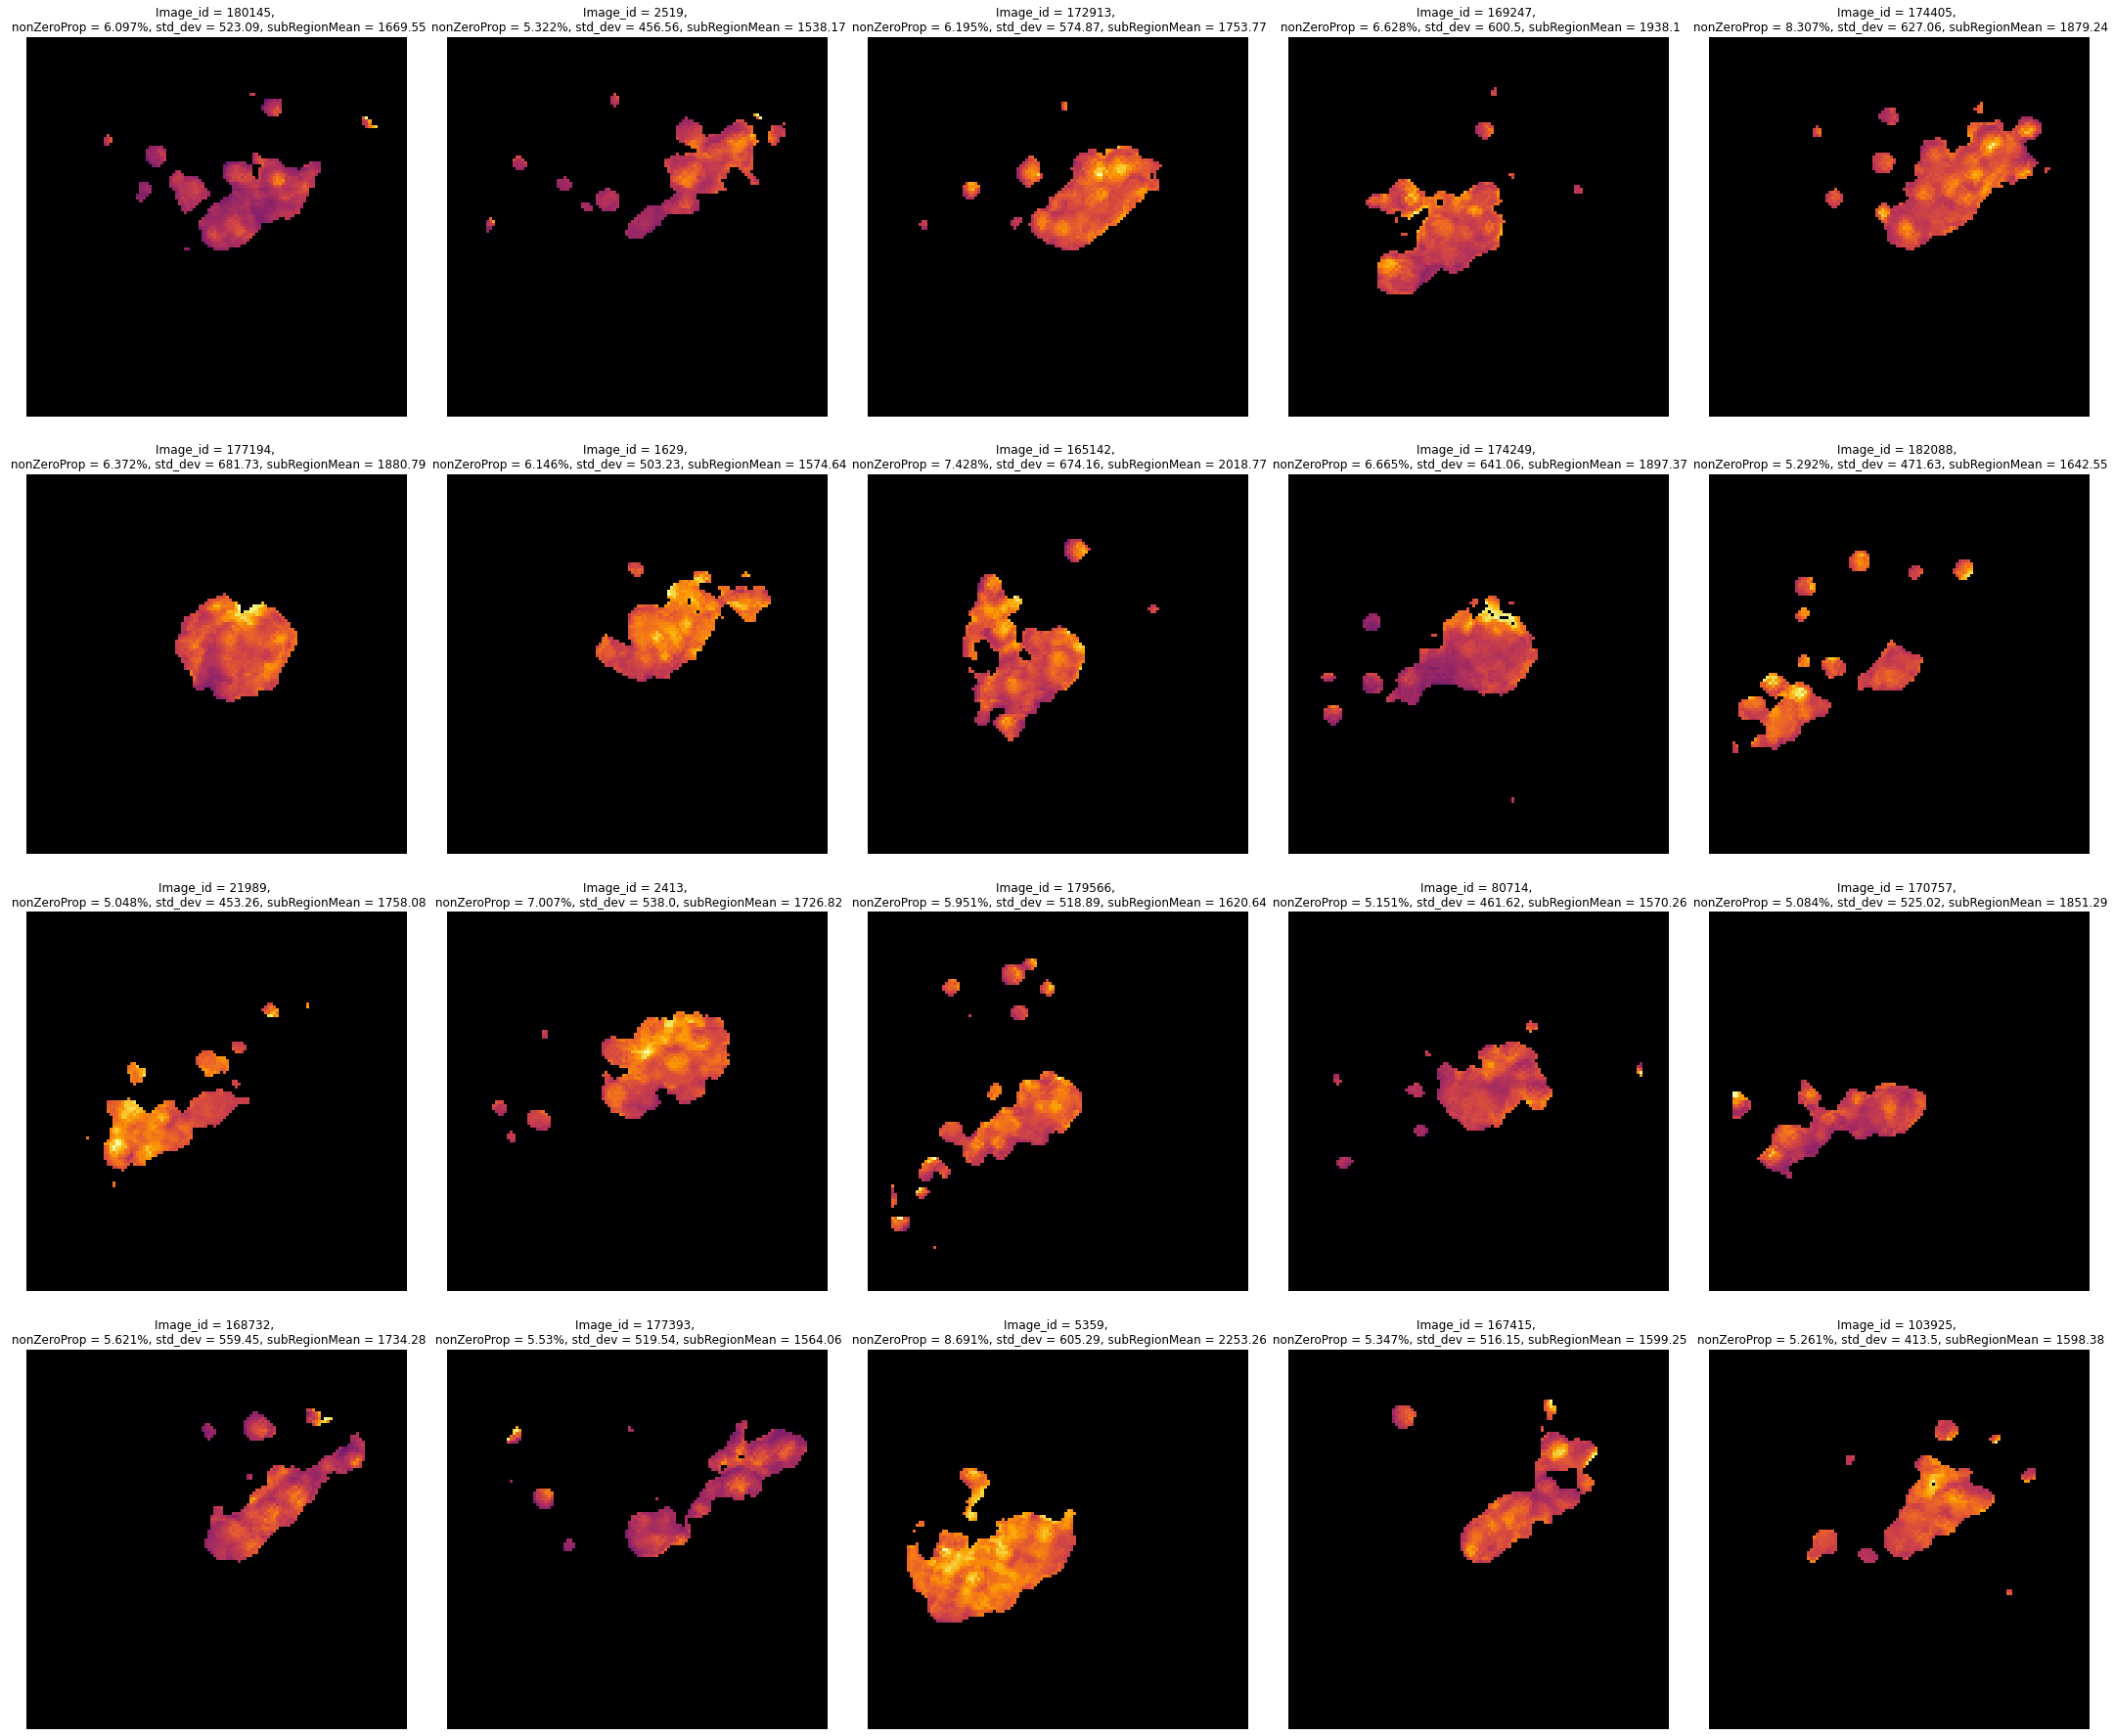

In [80]:
# Between 5% to 10% of non zero pixels
col = 'nonZeroProp'
lowerBound = 0.05
upperBound = 0.1

# DISPLAY IMAGES
disp_images_within_bound(lower_bound=lowerBound, higher_bound=upperBound, col=col, number_of_images=20, df=features_df, data=data)   

And finally, take a look at what's happening in the high density region of the histogram

The lowerBound for nonZeroProp is 0
The upperBound for nonZeroProp is 0.025


[27111,
 66068,
 80011,
 126907,
 143103,
 149678,
 152137,
 159289,
 164150,
 179098,
 191199,
 197104,
 206634,
 228033,
 234970,
 257335,
 274526,
 280094,
 346969,
 347077]

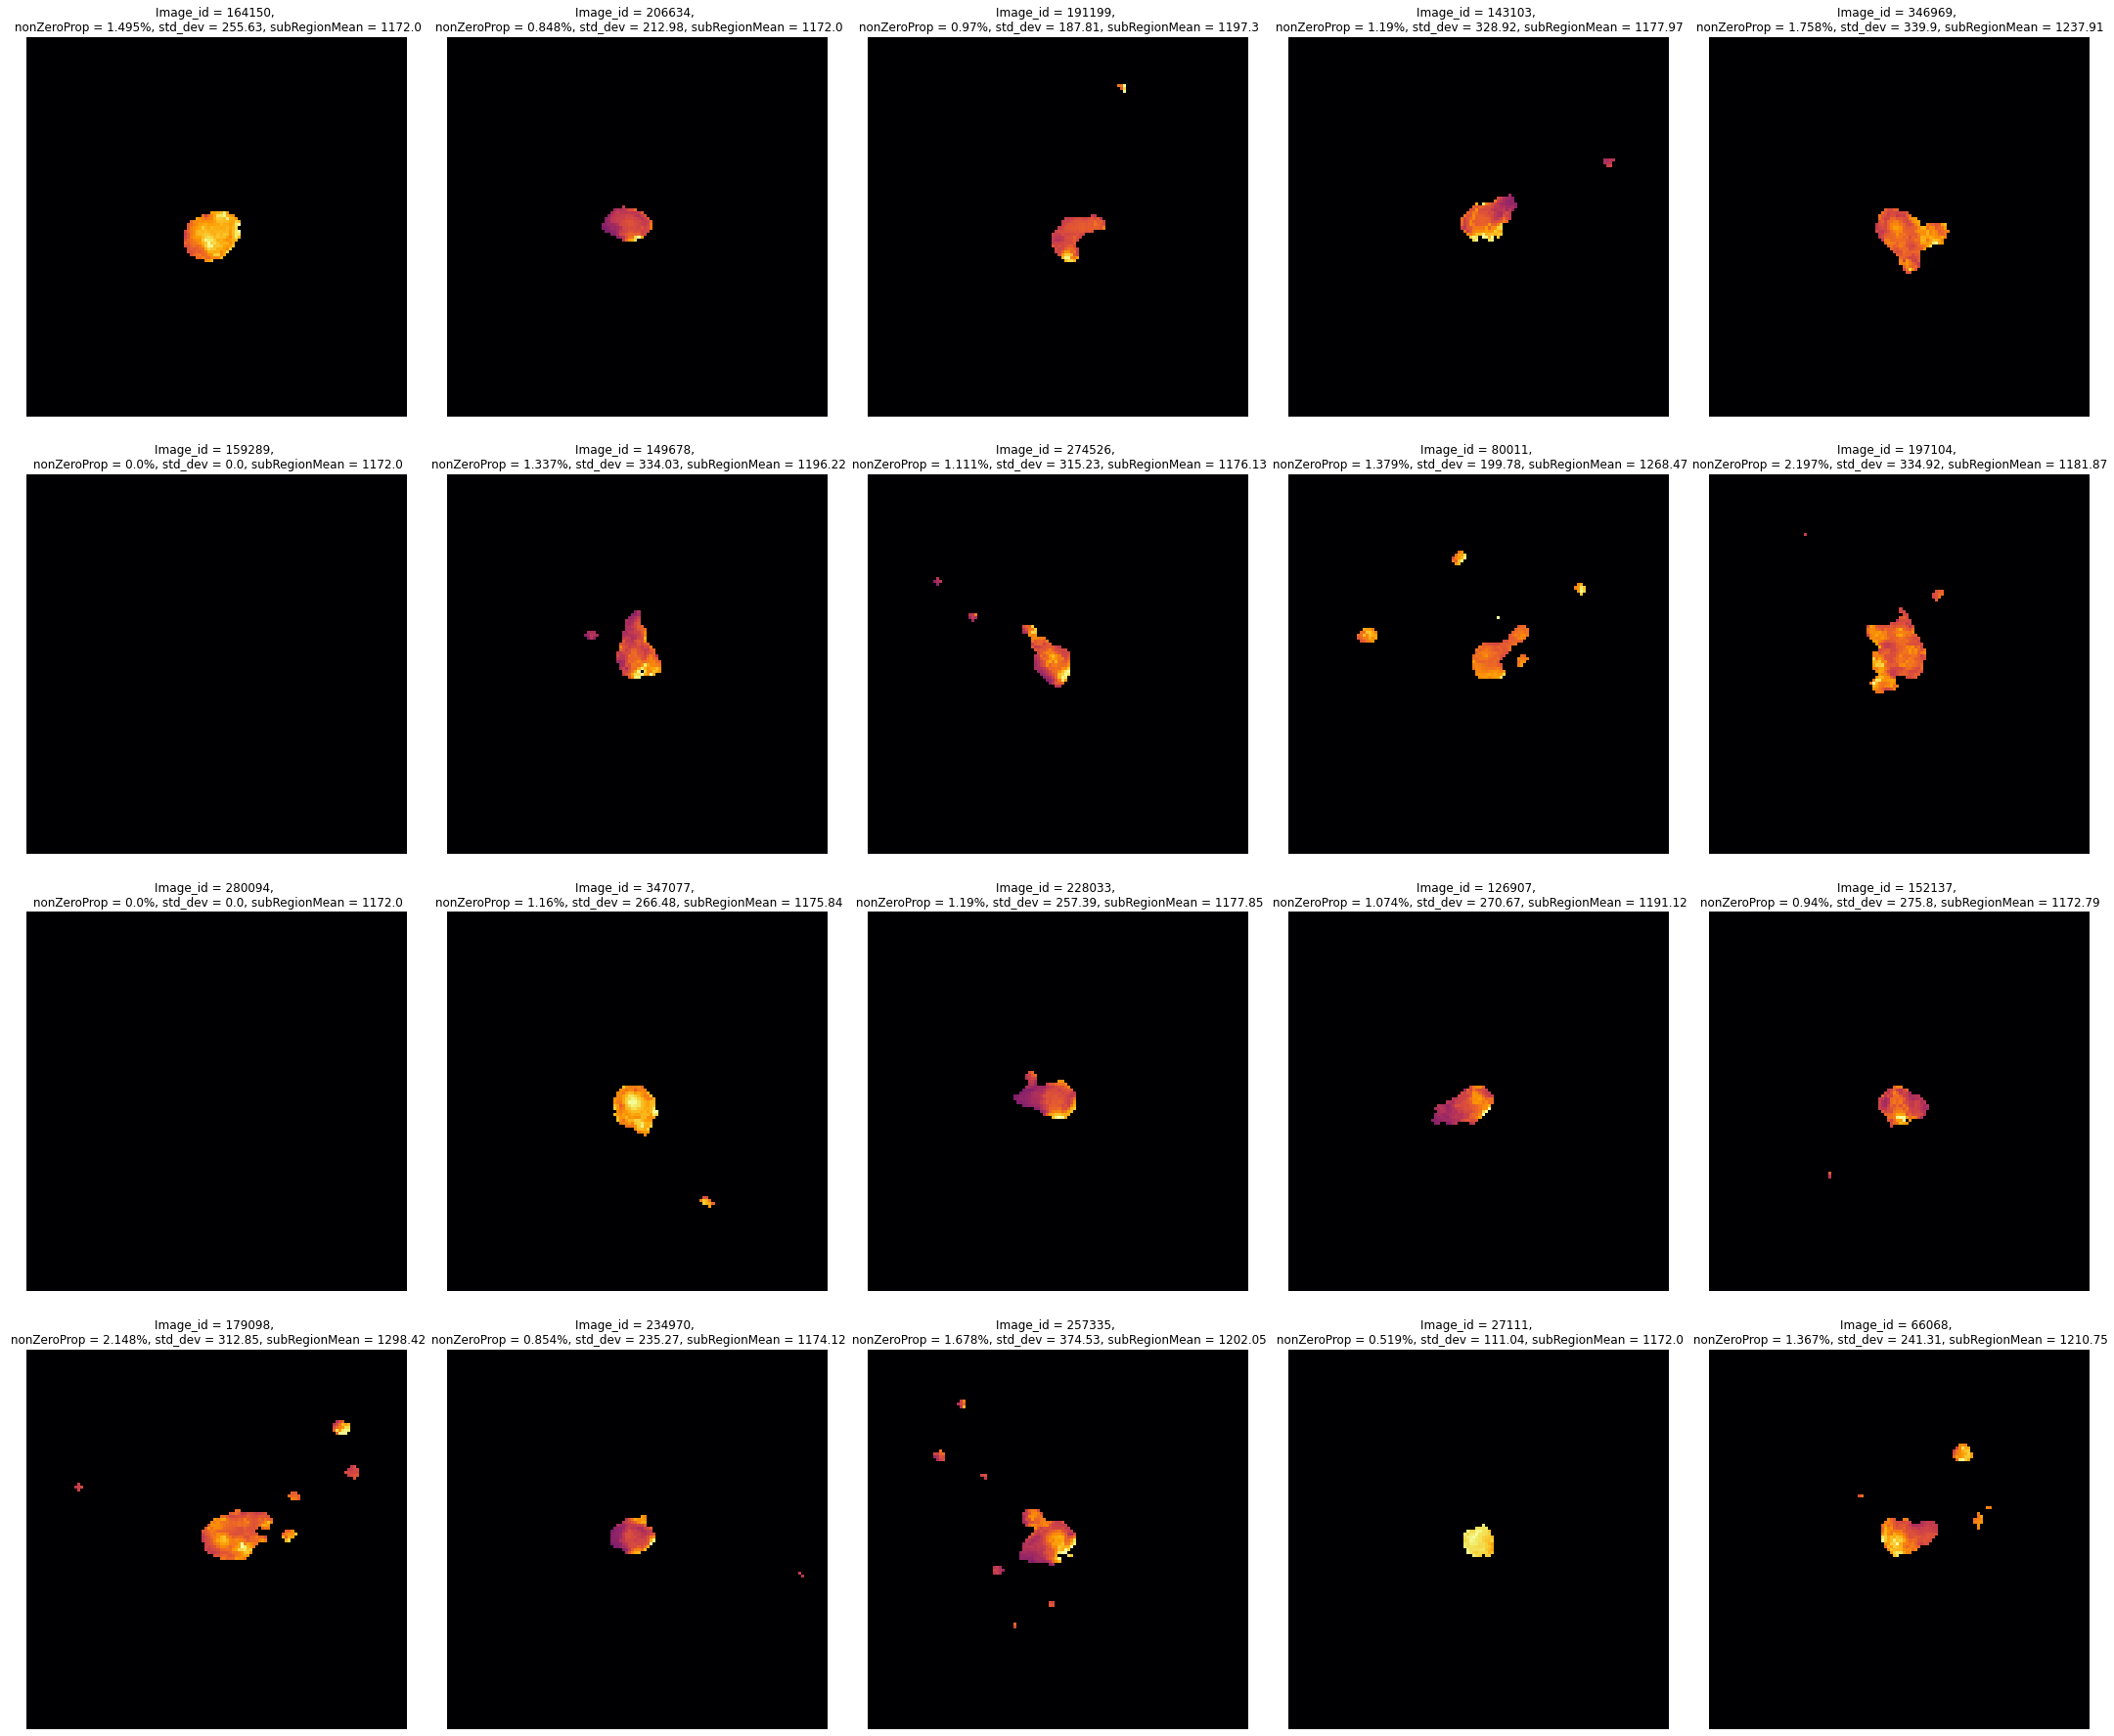

In [81]:
# Investigating the really low proportion part(high density region in the histogram)

col = 'nonZeroProp'

lowerBound = 0
upperBound = 0.025

# DISPLAY IMAGES
disp_images_within_bound(lower_bound=lowerBound, higher_bound=upperBound, col=col, number_of_images=20, df=features_df, data=data)

It seems that the laser beam in this region is more focus, meaning the energy density in this range of nonZeroProp should be higher.

Note that I could have segment the regions by percentile values. Nevertheless, this crude visualization reveals that:
1. Spatter particles occurs more frequently in image with higher proportion of non zero pixels.
2. At the tail of the non zero prop distribution, it seems like plume is captured in most of the images.
3. At lower non zero prop, the laser point is more focus.

### Std dev
It's harder to draw meaningful insight from std dev. Two images with the same std dev can look very different (Same pixel intenity distribution but different location of pixels will result in same std devitation) 


The lowerBound for std_dev is 100
The upperBound for std_dev is 200


[9146,
 9914,
 12634,
 16289,
 18171,
 28289,
 29777,
 30124,
 37824,
 77253,
 77634,
 81501,
 86359,
 106019,
 106949,
 107796,
 111003,
 117446,
 170892,
 187878]

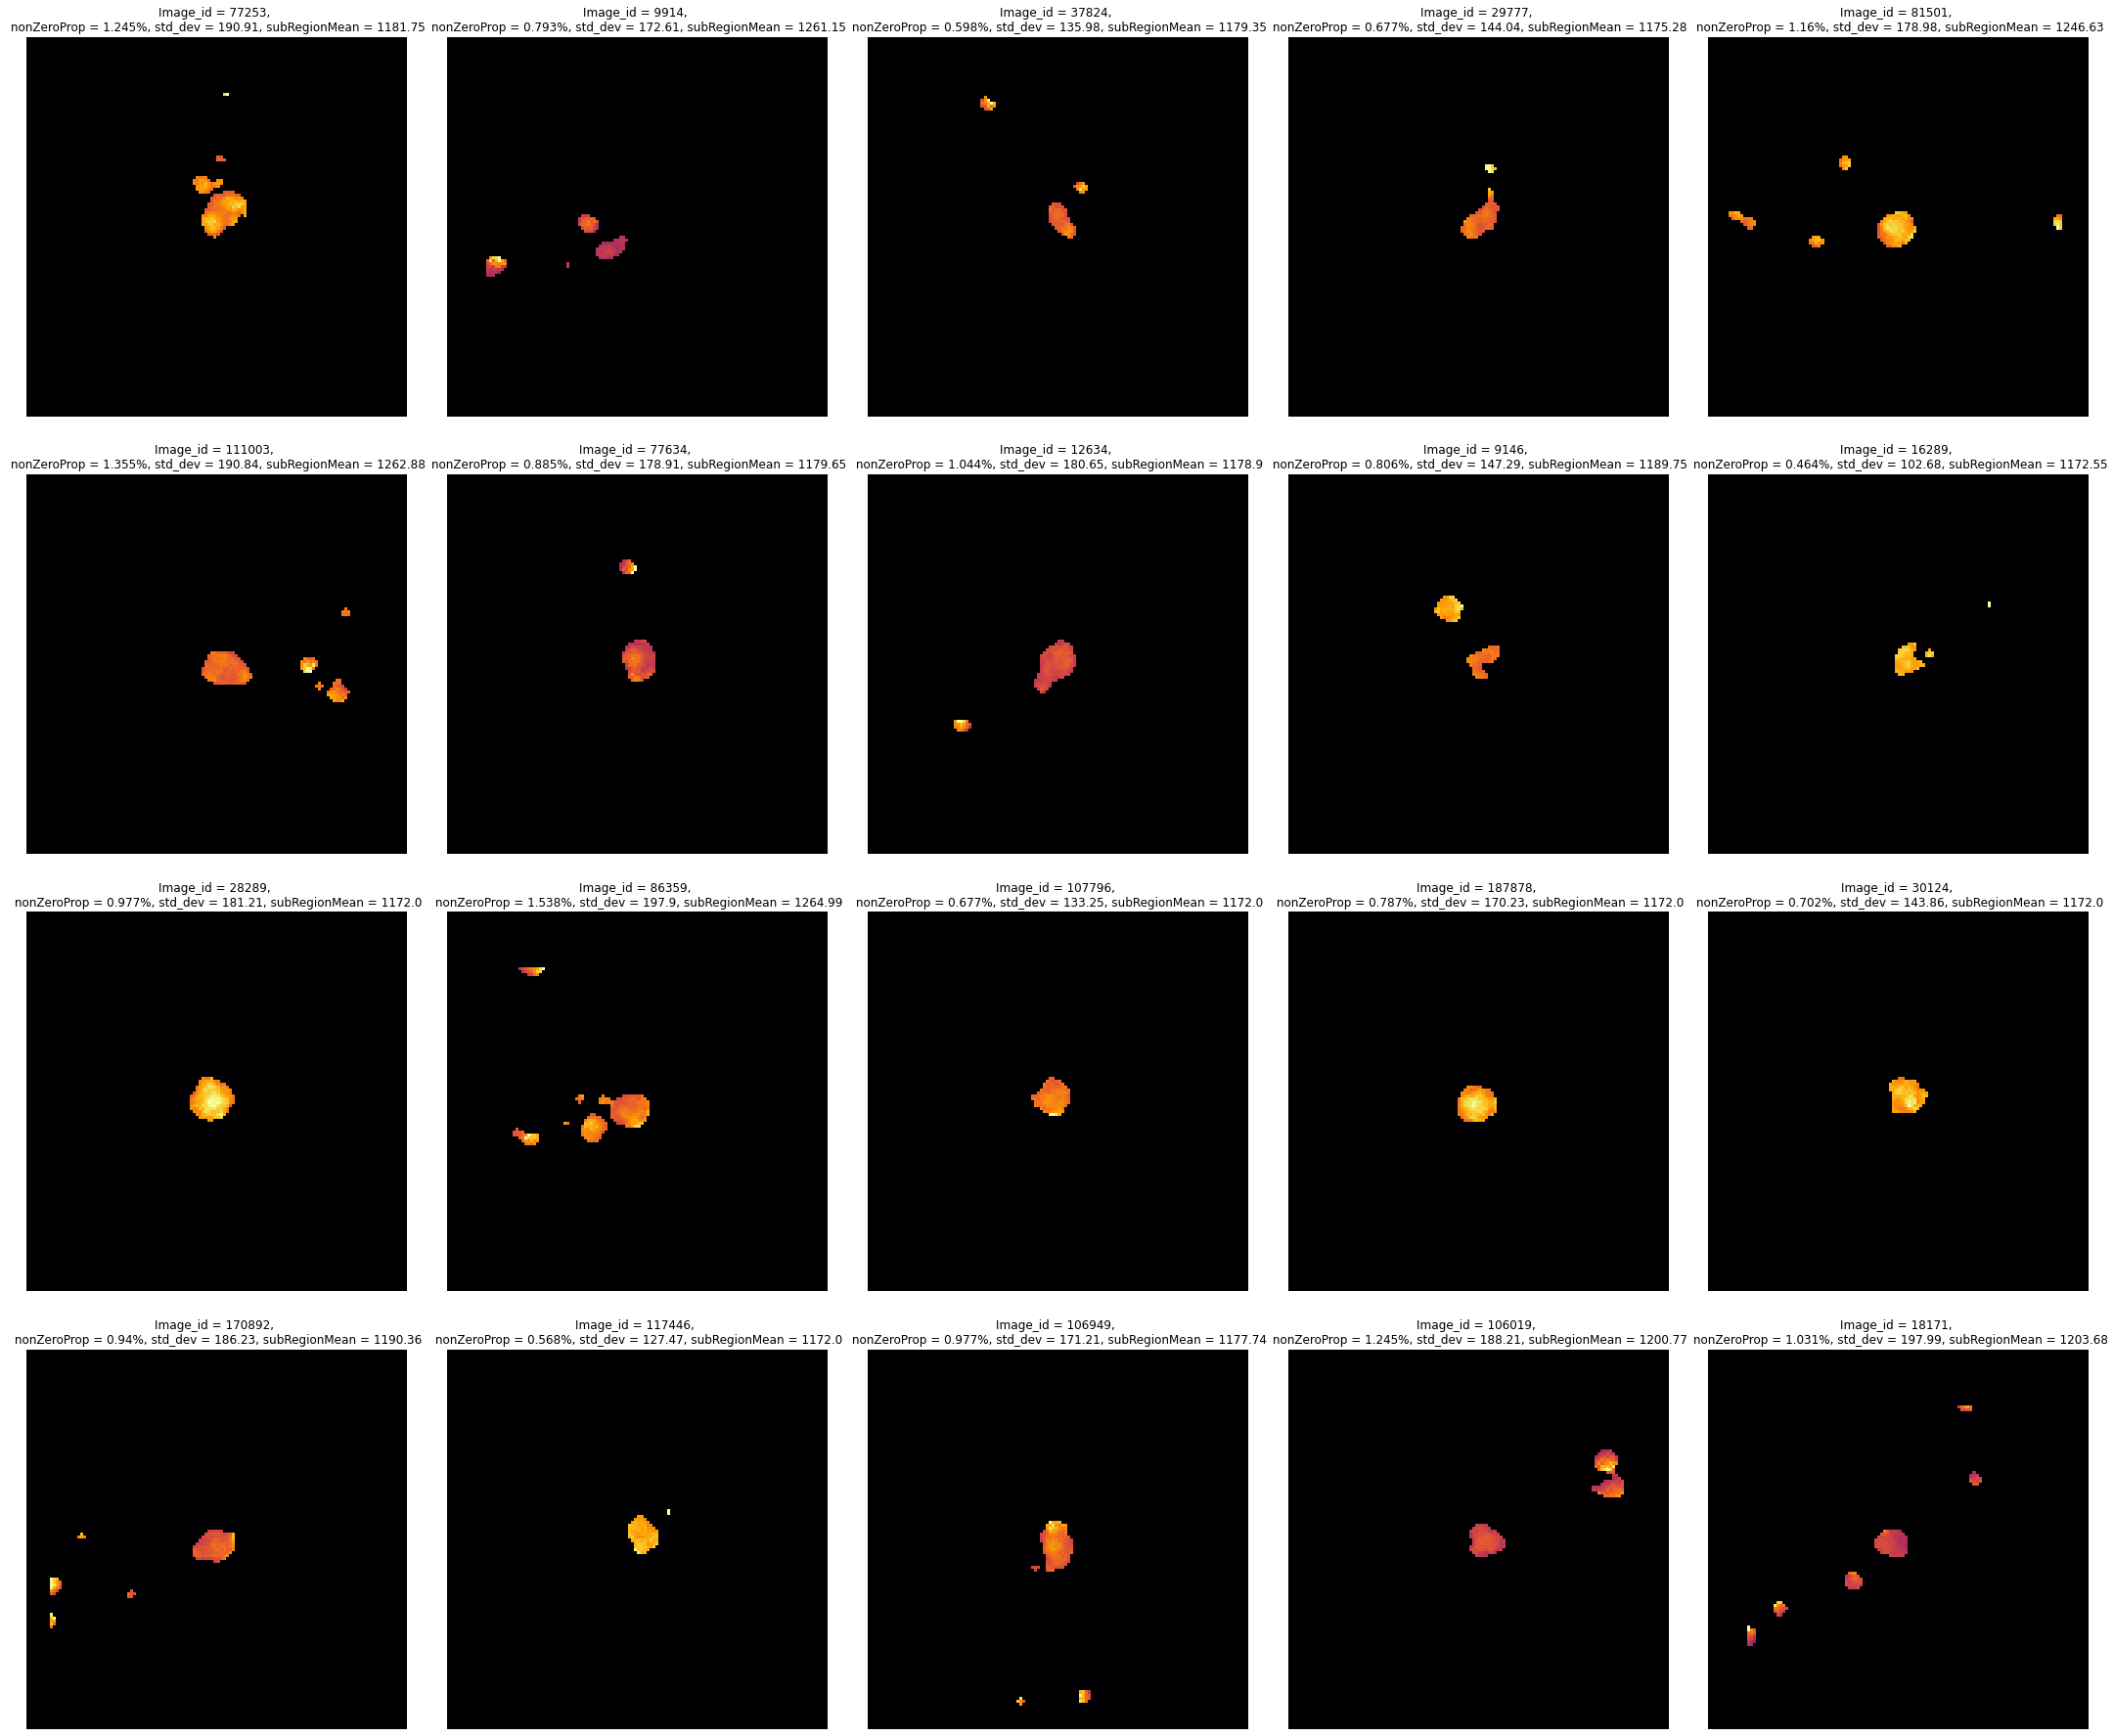

In [89]:
# Printing out several random images in the bound
# low end
col = 'std_dev'

lowerBound = 100
upperBound = 200

# DISPLAY IMAGES
disp_images_within_bound(lower_bound=lowerBound, higher_bound=upperBound, col=col, number_of_images=20, df=features_df, data=data)

The lowerBound for std_dev is 250
The upperBound for std_dev is 500


[26242,
 67384,
 96067,
 122105,
 124839,
 148757,
 171073,
 179653,
 184214,
 201789,
 205549,
 212832,
 222341,
 231175,
 248079,
 270977,
 278741,
 296534,
 314302,
 322198]

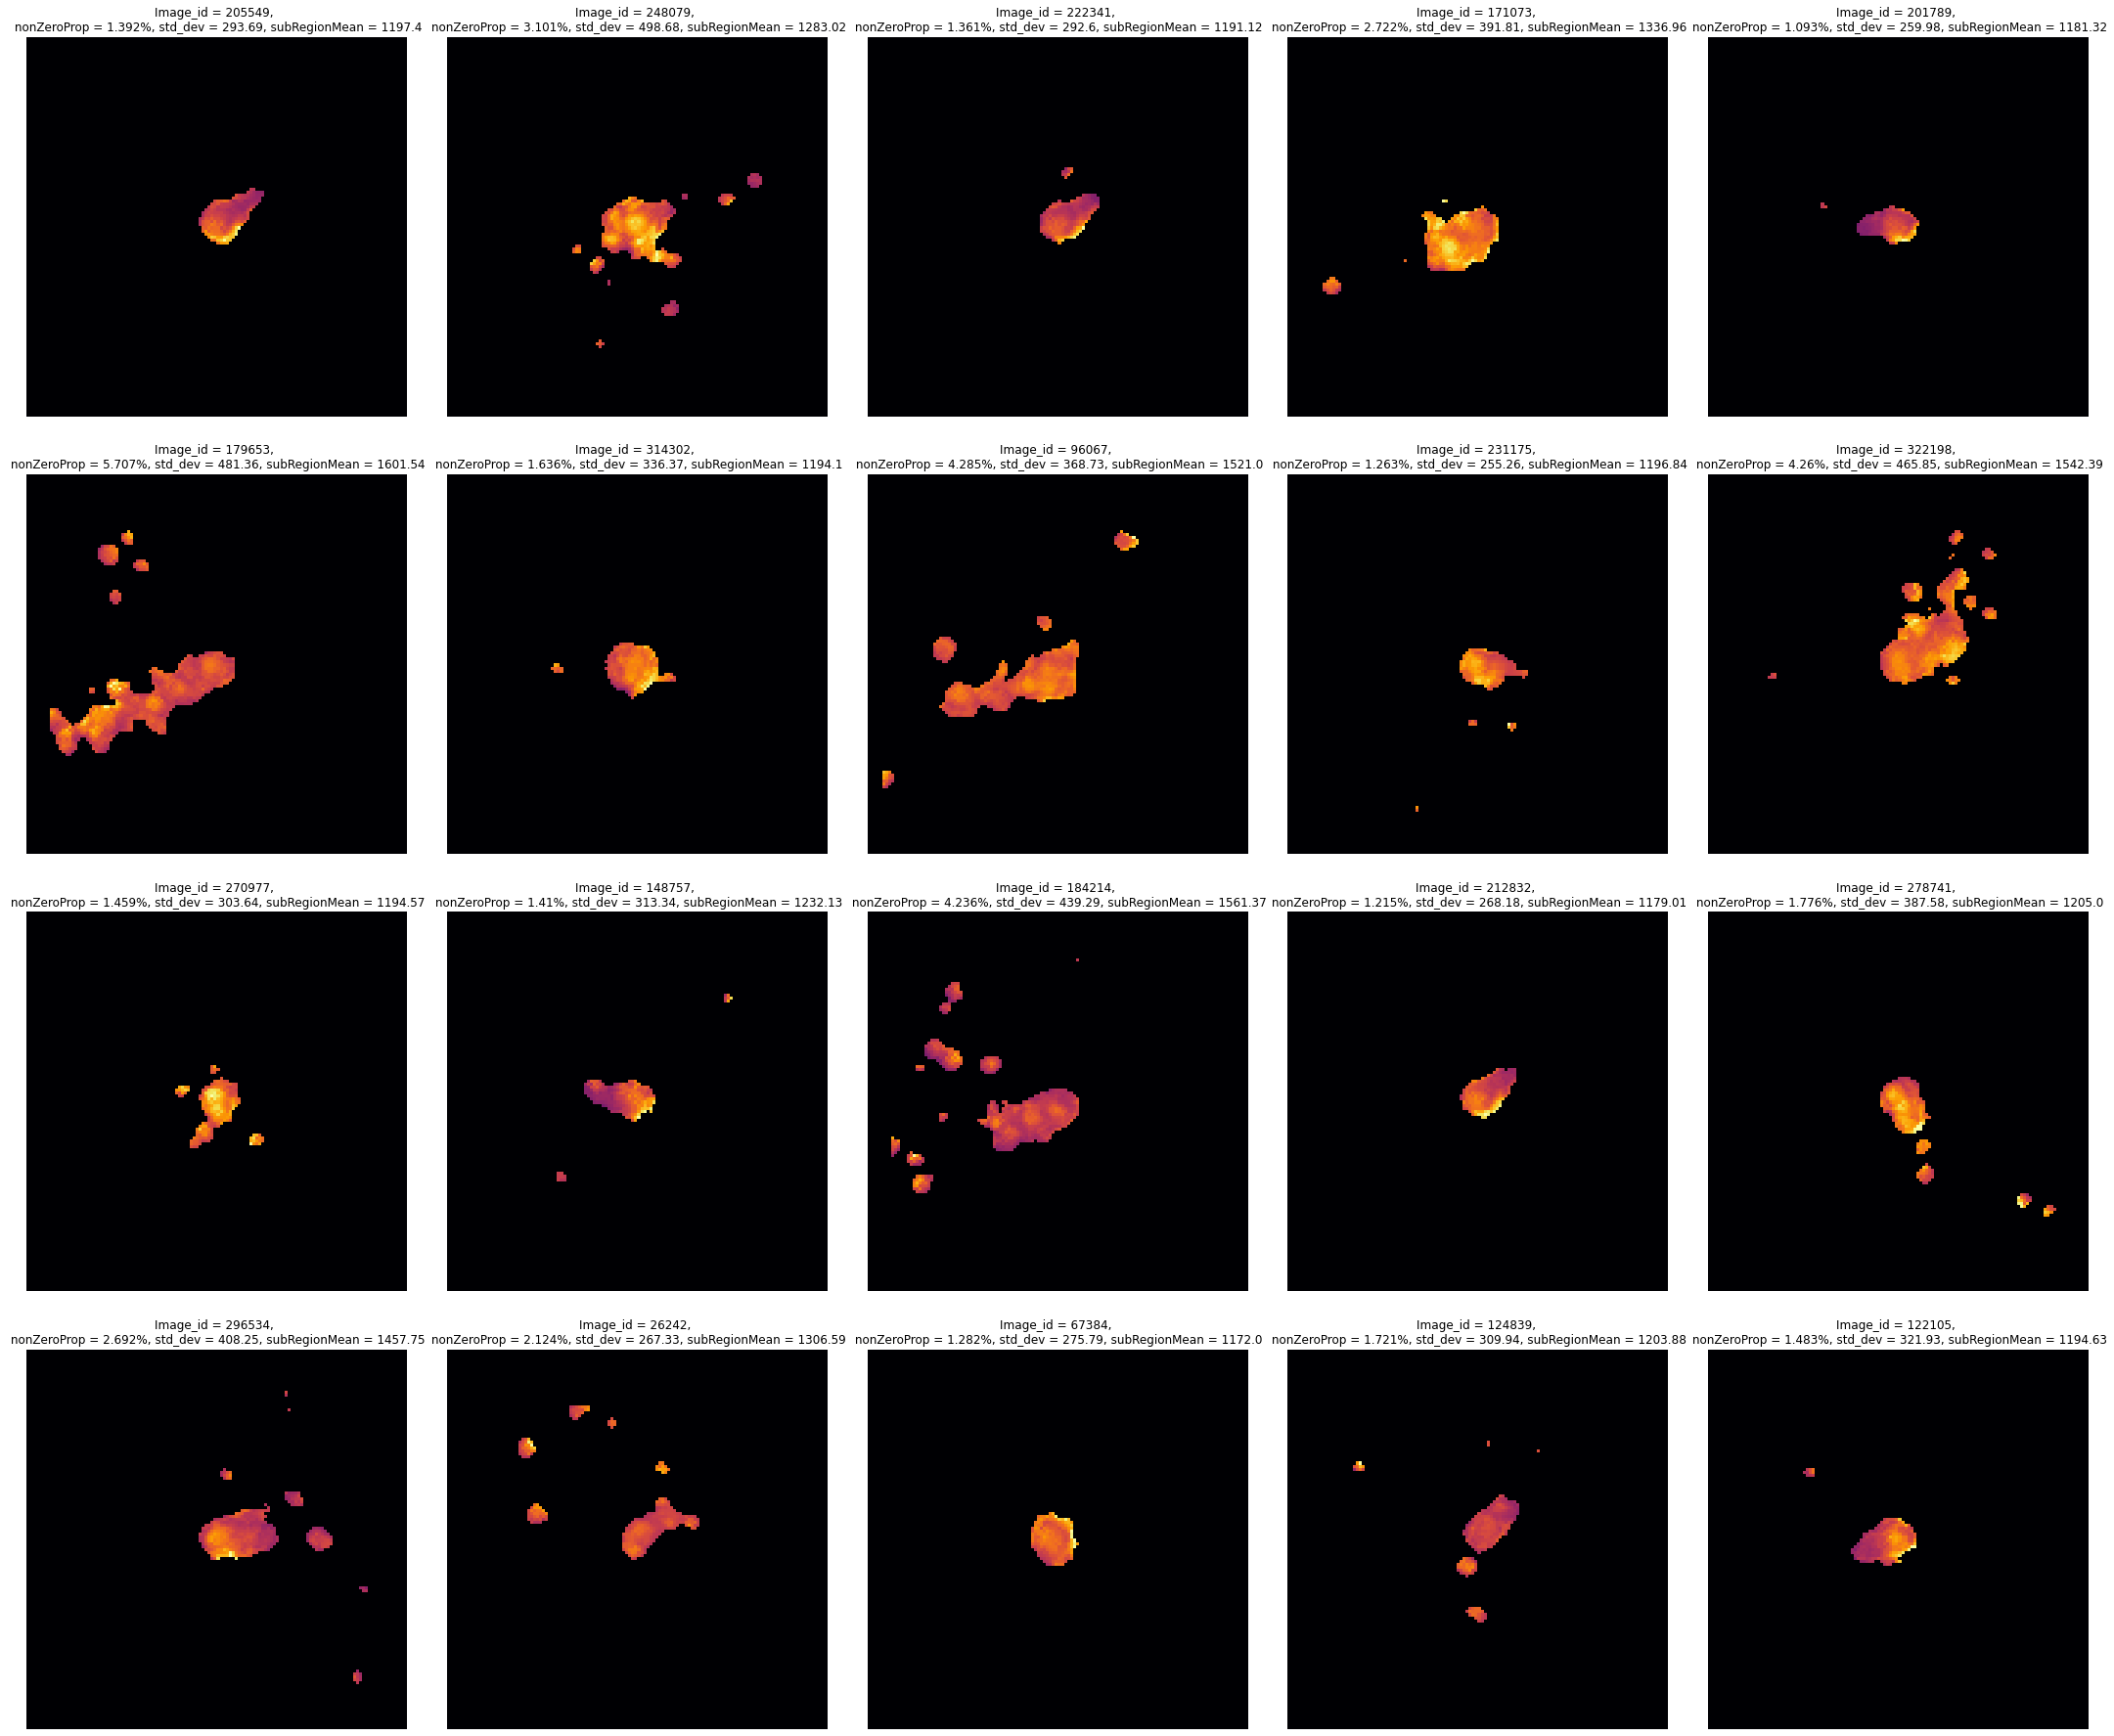

In [86]:
# Printing out several random images in the bound
# Middle part

col = 'std_dev'


lowerBound = 250
upperBound = 500

# DISPLAY IMAGES
disp_images_within_bound(lower_bound=lowerBound, higher_bound=upperBound, col=col, number_of_images=20, df=features_df, data=data)

The lowerBound for std_dev is 500
The upperBound for std_dev is 750


[5332,
 22050,
 24219,
 97330,
 161875,
 167708,
 172995,
 177917,
 178771,
 180141,
 180515,
 180735,
 181226,
 181414,
 181570,
 182593,
 182972,
 184390,
 185192,
 255164]

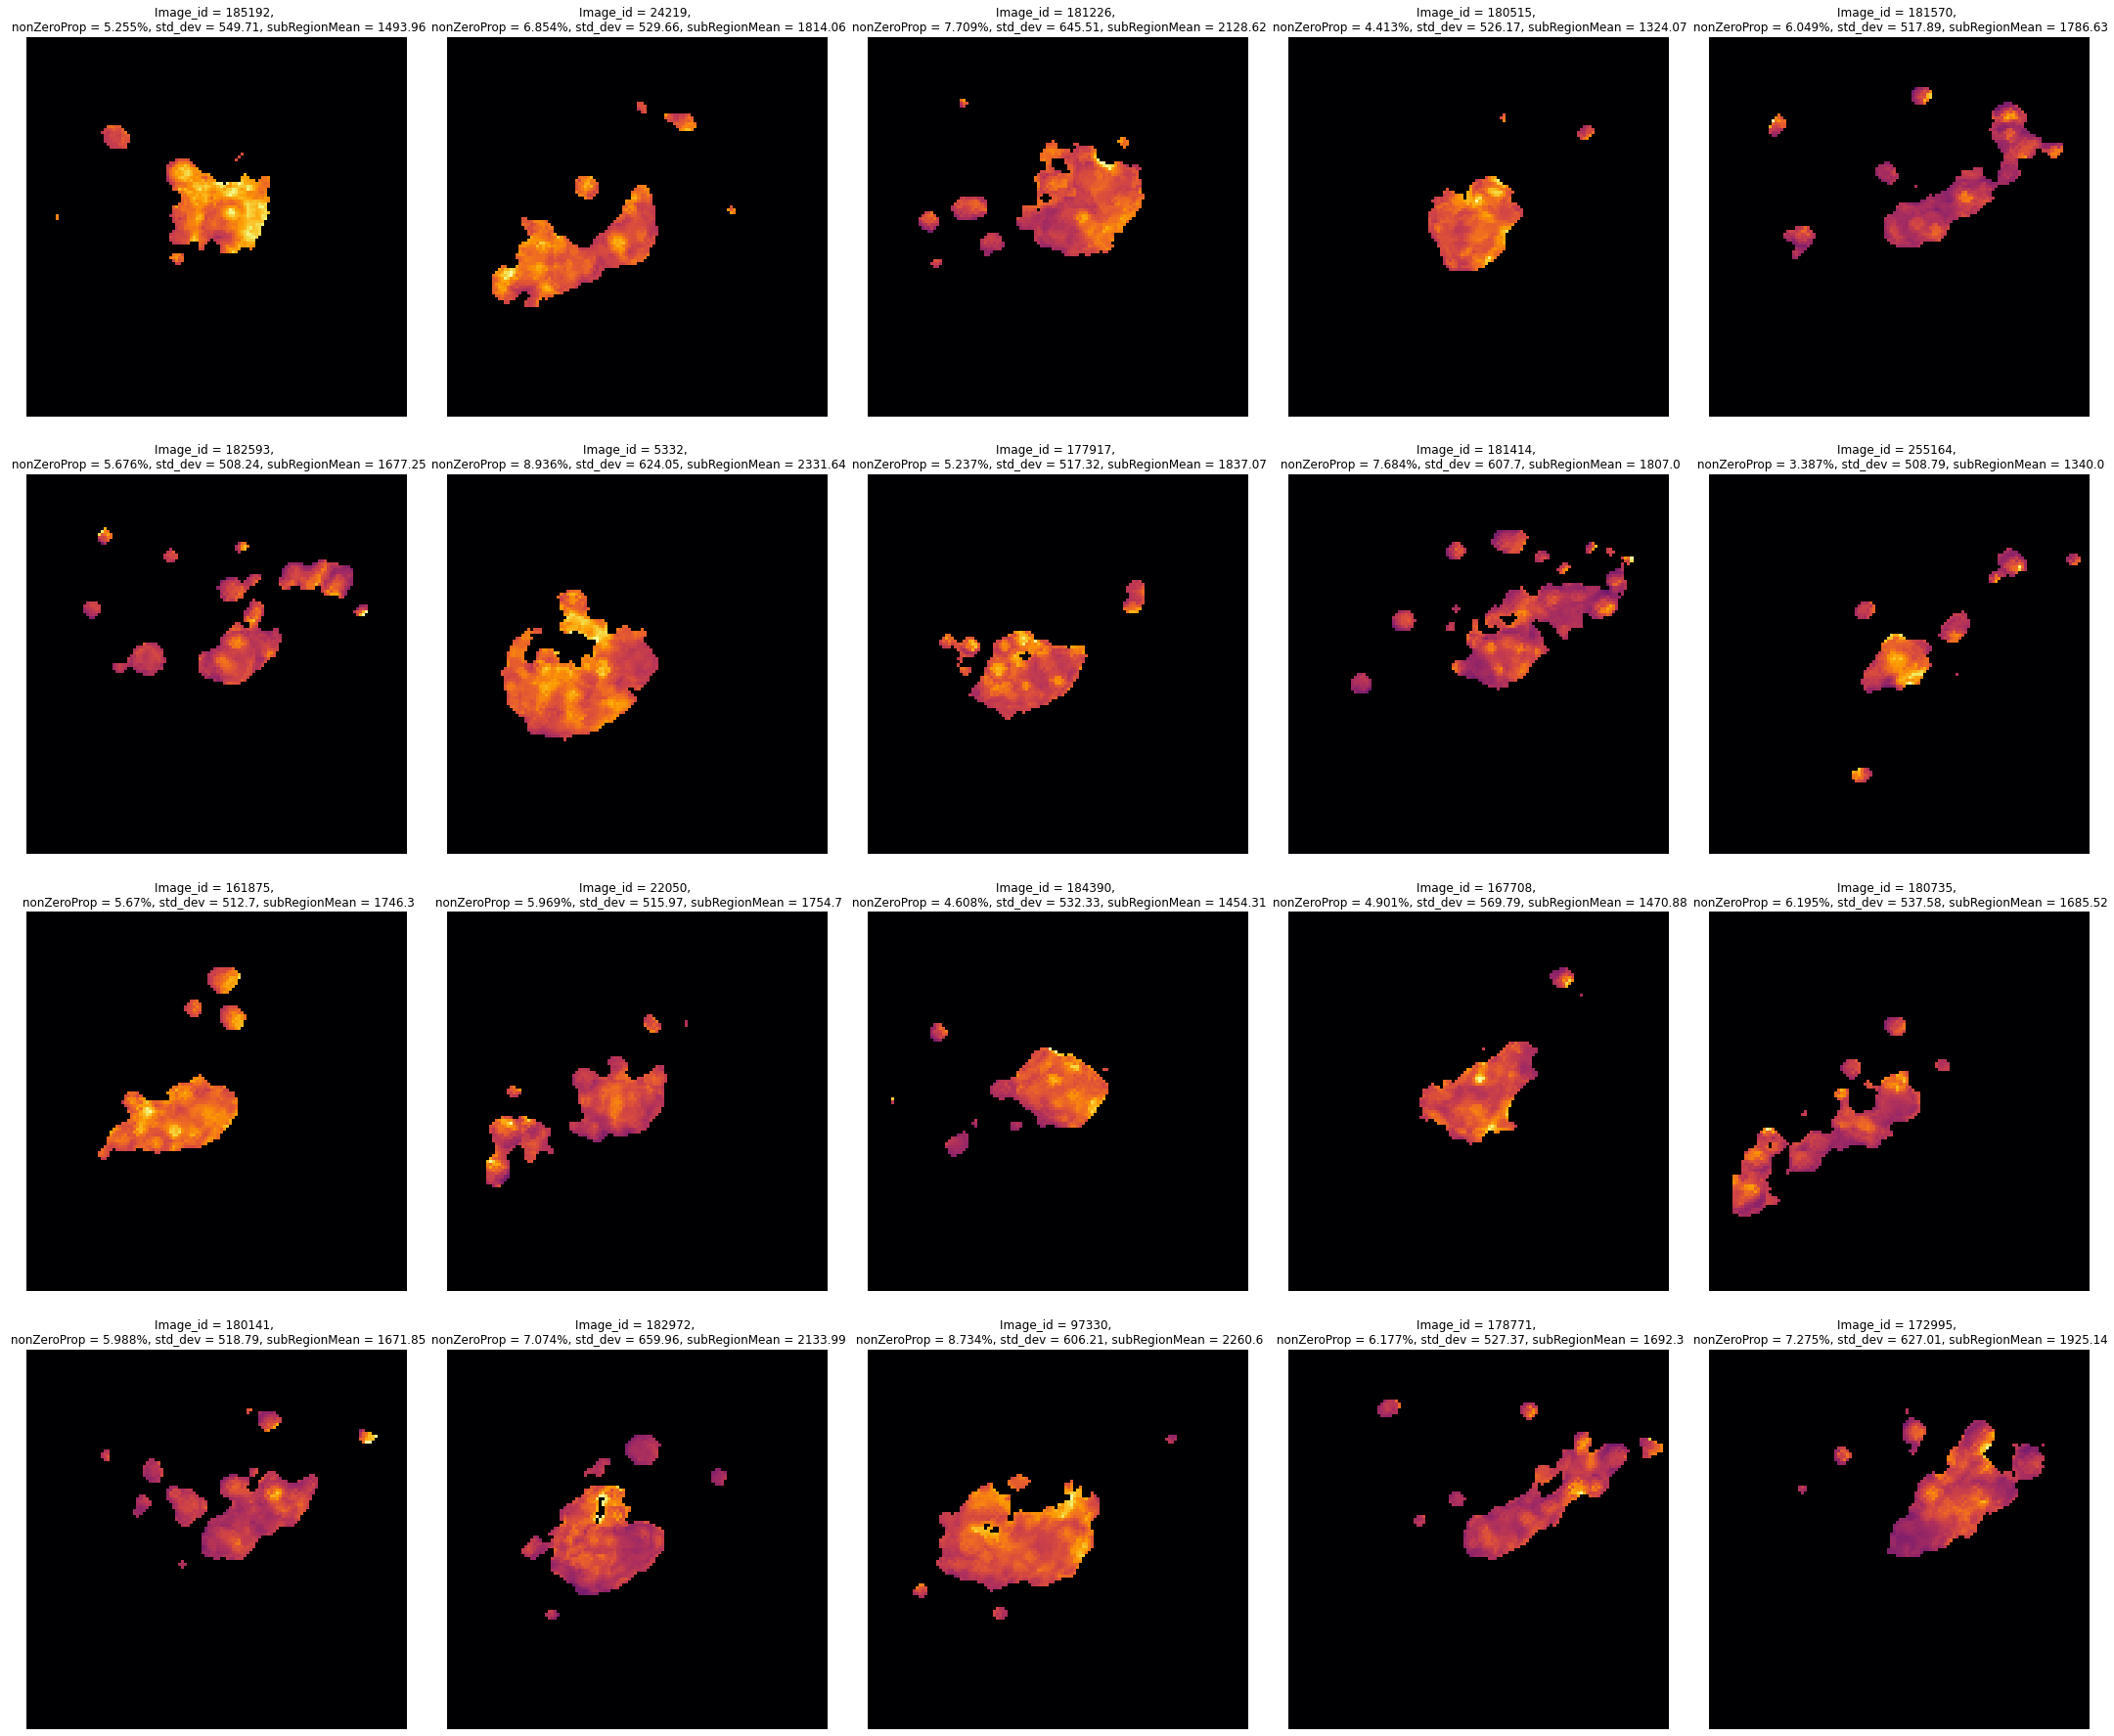

In [87]:
# Printing out several random images in the bound
# High end
col = 'std_dev'


lowerBound = 500
upperBound = 750

# DISPLAY IMAGES
disp_images_within_bound(lower_bound=lowerBound, higher_bound=upperBound, col=col, number_of_images=20, df=features_df, data=data)

It seems that at the very high end of the std dev distribution, the laser is very foucesd.

### subRegionMean
Let's inspect the third feature. Based on the histogram of this feature, the distribution is highly skewed.



In the first region, where the mean values are low, we would expect the laser to be much focus and the spatter particles detected should be minimal. Also, generally smaller laser spots.

The lowerBound for subRegionMean is 1172.0
The upperBound for subRegionMean is 1187.3707788461538


[12636,
 12750,
 32626,
 71454,
 71694,
 134534,
 141235,
 147645,
 164128,
 198465,
 199095,
 203183,
 206280,
 206534,
 210443,
 211610,
 227524,
 234625,
 240016,
 347409]

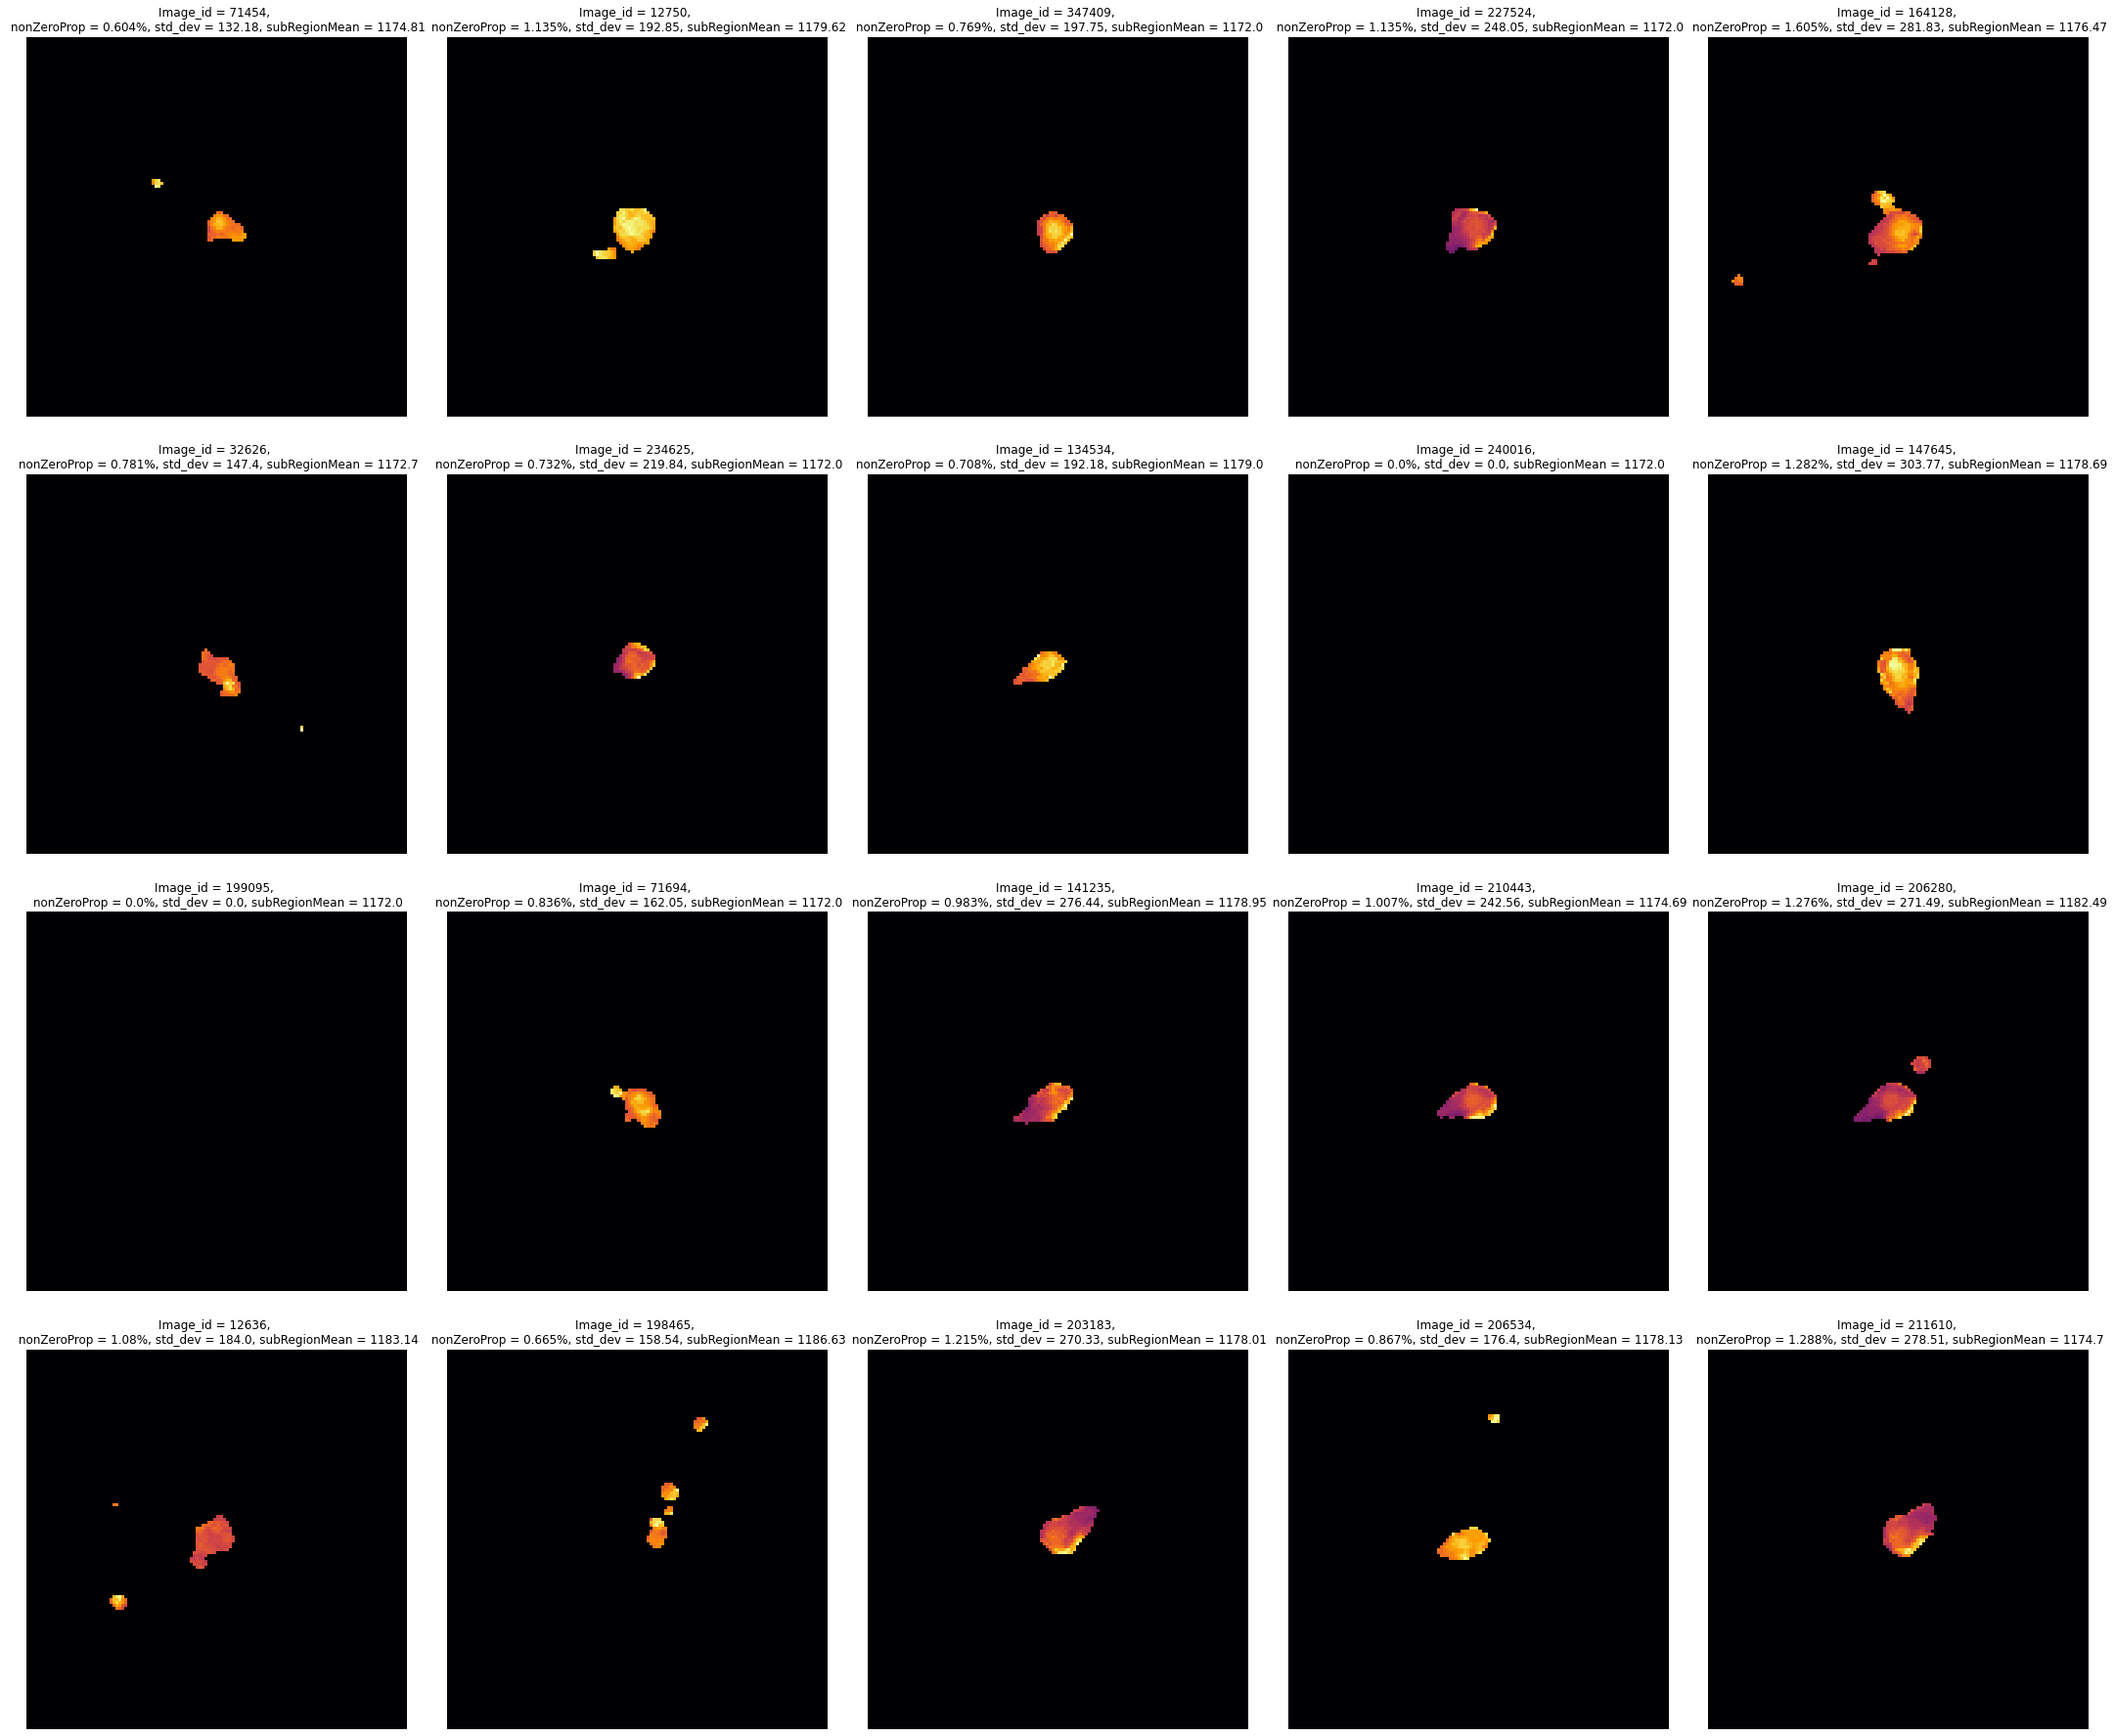

In [93]:
# Printing out several random images in the bound

col = 'subRegionMean'


lowerBound = features_df[col].quantile(0)
upperBound = features_df[col].quantile(0.3)

# DISPLAY IMAGES
disp_images_within_bound(lower_bound=lowerBound, higher_bound=upperBound, col=col, number_of_images=20, df=features_df, data=data)

In the second region, the spatter particles starts to appear in the image.

The lowerBound for subRegionMean is 1187.3707788461538
The upperBound for subRegionMean is 1224.3232165582579


[8373,
 9122,
 31575,
 34466,
 86305,
 89041,
 133510,
 142367,
 201501,
 212603,
 221045,
 269591,
 272095,
 295516,
 299899,
 311722,
 316565,
 316722,
 331659,
 337627]

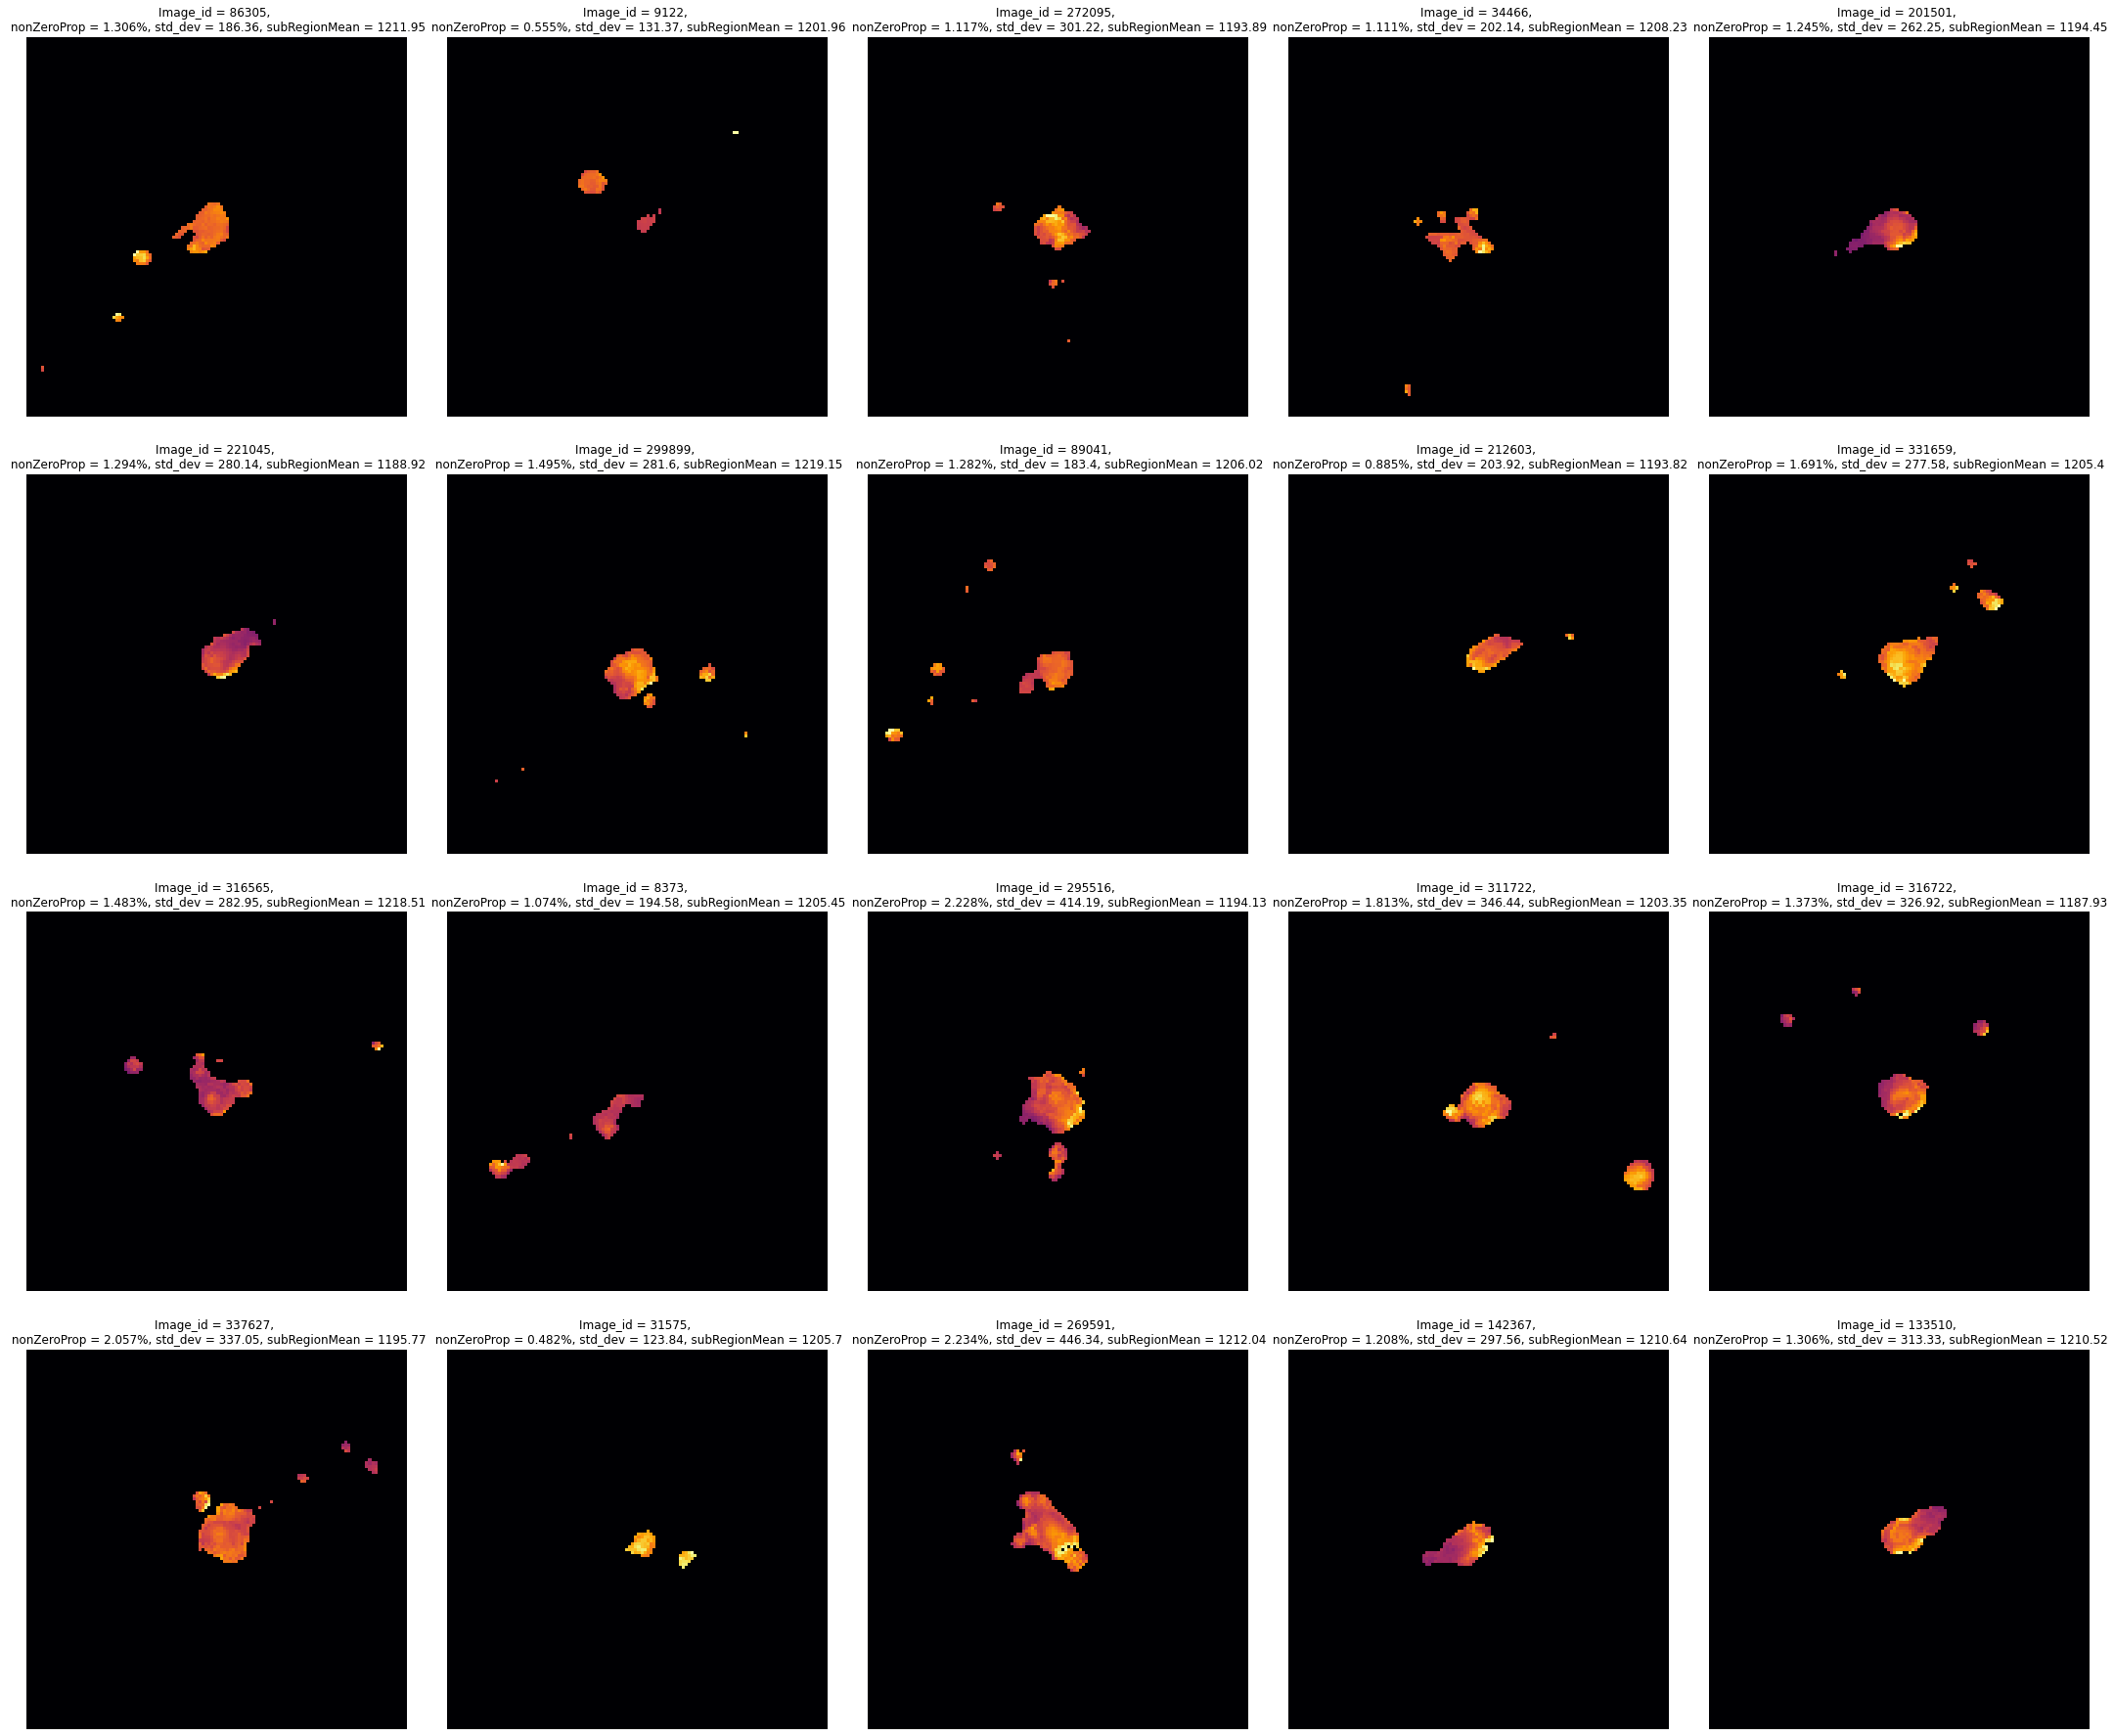

In [96]:
# Printing out several random images in the bound

col = 'subRegionMean'


lowerBound = features_df[col].quantile(0.3)
upperBound = features_df[col].quantile(0.5)

# DISPLAY IMAGES
disp_images_within_bound(lower_bound=lowerBound, higher_bound=upperBound, col=col, number_of_images=20, df=features_df, data=data)

In the third region, the spatter particles are scattered around in the image. Also, more spatter particles.

The lowerBound for subRegionMean is 1314.9641555901208
The upperBound for subRegionMean is 2982.5856962905355


[1062,
 1153,
 8965,
 13010,
 49191,
 49778,
 162544,
 168469,
 172934,
 185165,
 248161,
 249629,
 255716,
 263762,
 264701,
 286264,
 287892,
 322929,
 335544,
 337067]

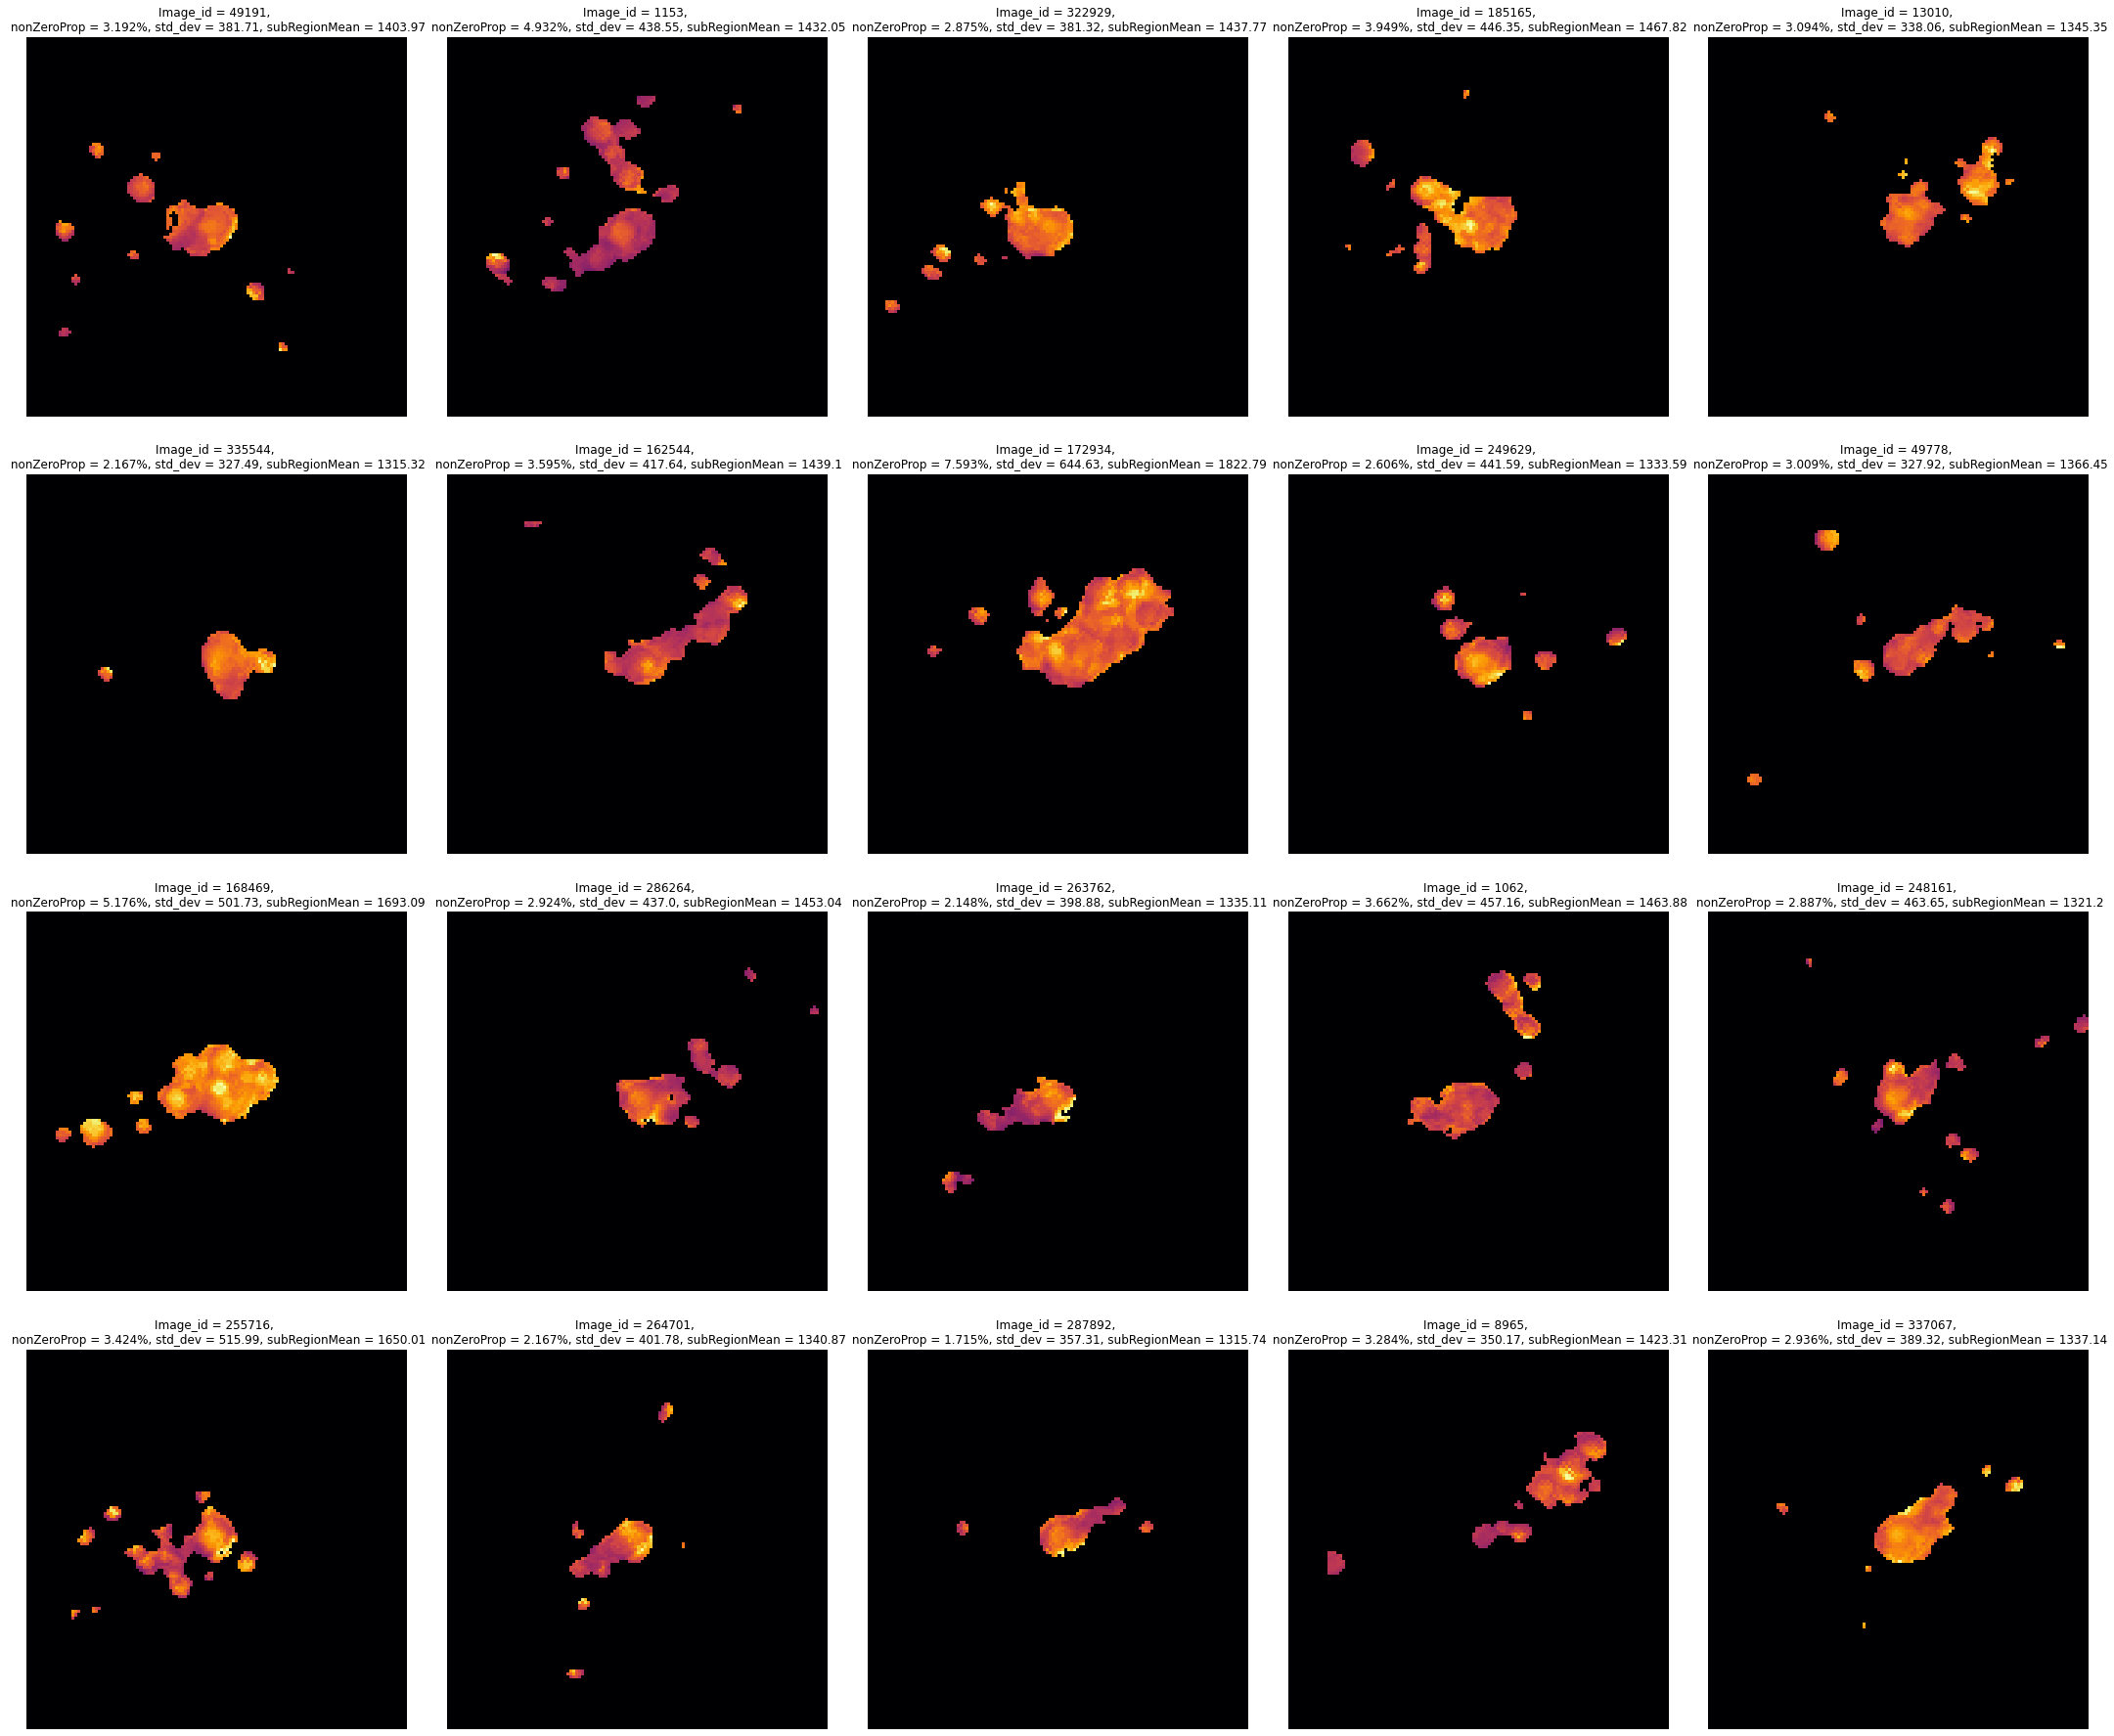

In [97]:
# Printing out several random images in the bound

col = 'subRegionMean'

lowerBound = features_df[col].quantile(0.75)
upperBound = features_df[col].quantile(1.0)

# DISPLAY IMAGES
disp_images_within_bound(lower_bound=lowerBound, higher_bound=upperBound, col=col, number_of_images=20, df=features_df, data=data)

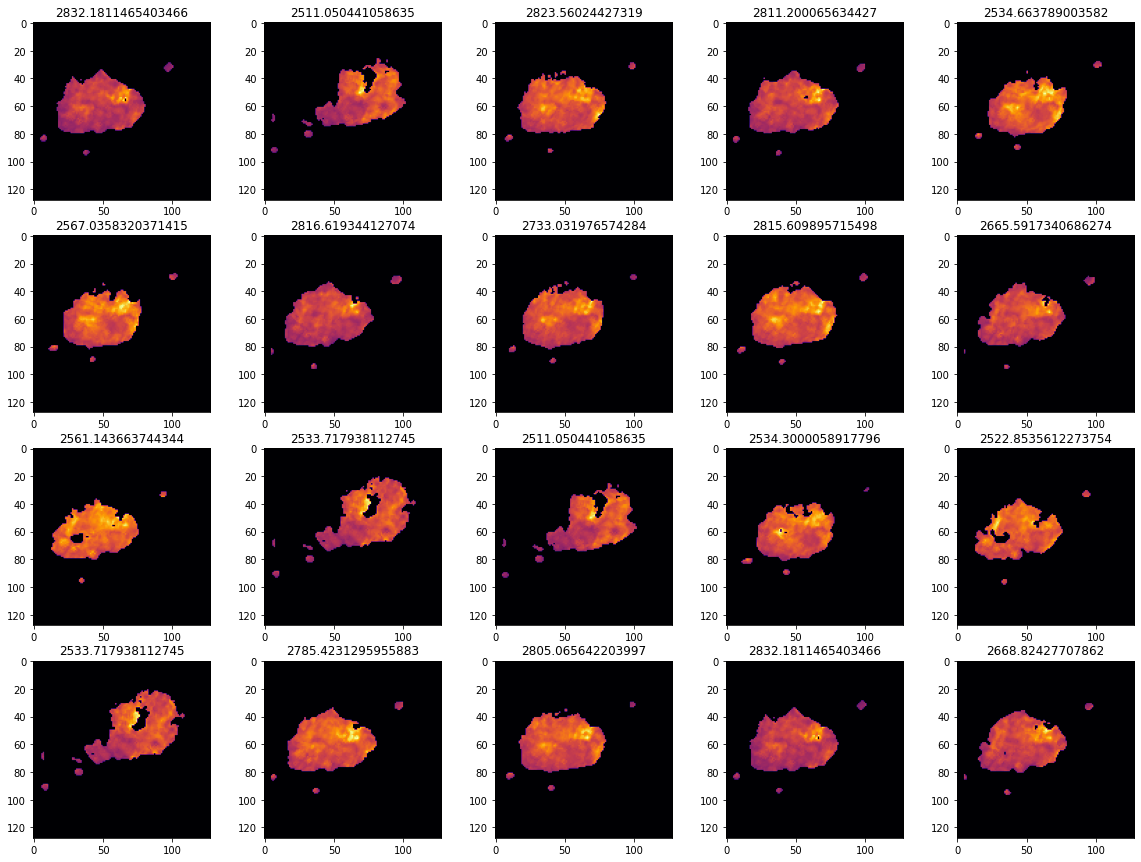

In [101]:
# The slices Mean at very high end is populated by image with plume
s = features_df[features_df['subRegionMean']>2500].index
i = np.random.randint(low=0, high = len(s))

fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(20, 15))

axes = axes.flatten()

for ax in axes:
  i = np.random.randint(low=0, high = len(s))
  ax.imshow(data[s[i]], cmap='inferno')
  ax.set_title(features_df['subRegionMean'].iloc[s[i]])

## Plotting for all 3 features against time

### Overlaying all the graphs
Normalize the values for fair comparison

In [103]:
temp = min_max_norm(features_df)

In [127]:
# Overlay both graphs, normalize the values

print('####### Correlation #######')
print(temp.corr())
print('###########################')

####### Correlation #######
                std_dev  nonZeroProp  subRegionMean
std_dev        1.000000     0.834035       0.683311
nonZeroProp    0.834035     1.000000       0.892685
subRegionMean  0.683311     0.892685       1.000000
###########################


In [105]:
import plotly.graph_objects as go

# interactive graph to zoom into particular region/ get the index in region of interest

fig = go.Figure()
# Ignore std dev
# fig.add_trace(go.Scatter(x=time, y=temp['std_dev'][::100],mode='lines+markers',
#                     name='normalized std dev'))
fig.add_trace(go.Scatter(x=time, y=temp['nonZeroProp'][::100],mode='lines+markers',
                    name='normalized non zero prop'))
fig.add_trace(go.Scatter(x=time, y=temp['subRegionMean'][::100],mode='lines+markers',
                    name='normalized subRegionMean'))


fig.show()

#### Investigating the images based on image Id
Based on previous visualizations, let's take a look into the data in more detail.

In [122]:
# Plot
# The images are not displayed in gray scale to make the spatter particles visible
def disp_images(index,n= 50, norm_df=temp, data=data, jump =1000):
  
  fig, axes = plt.subplots(nrows=int(n/5), ncols=5, figsize=(30, 25))
  
  count = index
  
  axes = axes.flatten()
  plt.tight_layout()
  for i in range(n):
    ax = axes[i]
    
    ax.imshow(data[count], cmap='inferno')
    ax.set_axis_off()
    ax.set_title('imageId: {} \n std: {}, prop : {}, mean : {}'.format(count, round(temp['std_dev'].iloc[count], 3), round(temp['nonZeroProp'].iloc[count], 3), round(temp['subRegionMean'].iloc[count], 3)))
    count+=jump

Based on the interactive graph, this should cover the transition stage of the laser beam
If we zoom into the graph, the laser was off at imageId ~38.7k and indeed there is nothing in the corresponding image. disp_images function should be used along with the interactive plot to explore different regions on the graph.

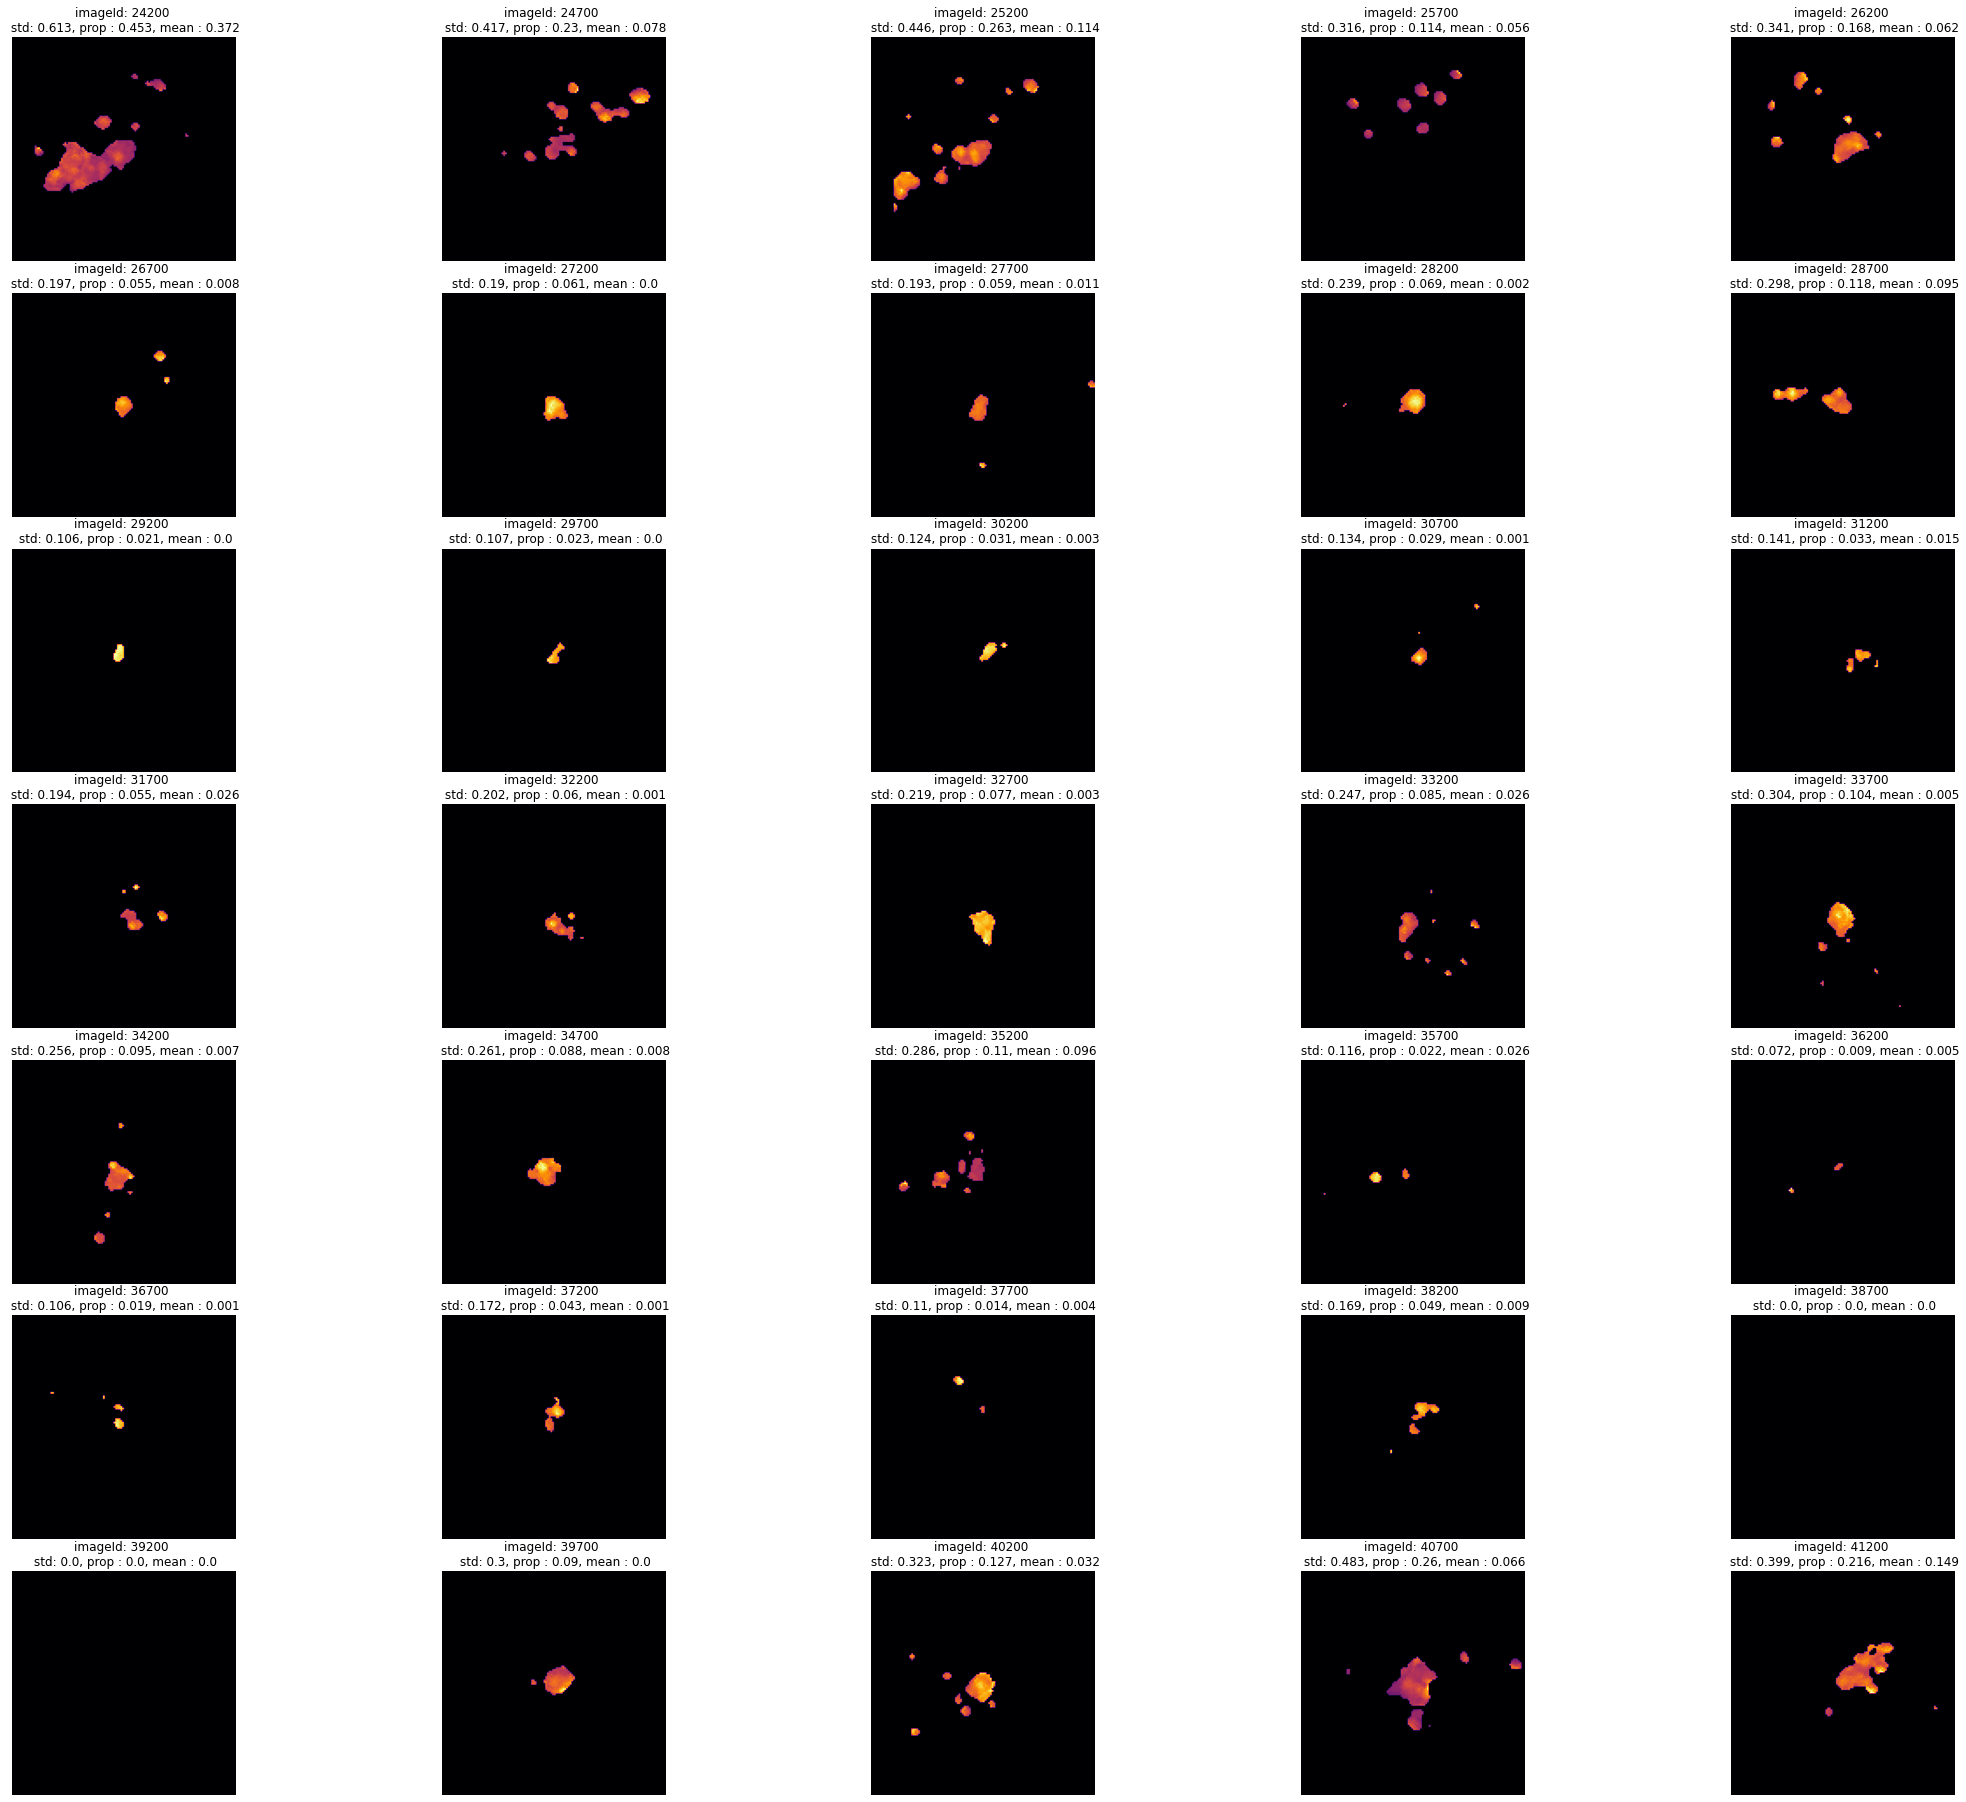

In [123]:
# sequentially print out every jump=500 image
disp_images(index = 24200, n = 35, jump=500)

### Plume 

97347


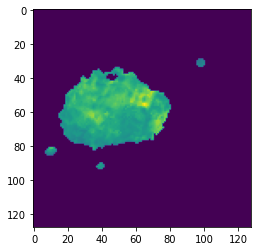

In [124]:
# Let's take a look at the image with biggest coverage
plt.imshow(data[temp['nonZeroProp'].idxmax()])
print(temp['nonZeroProp'].idxmax())
plt.show()

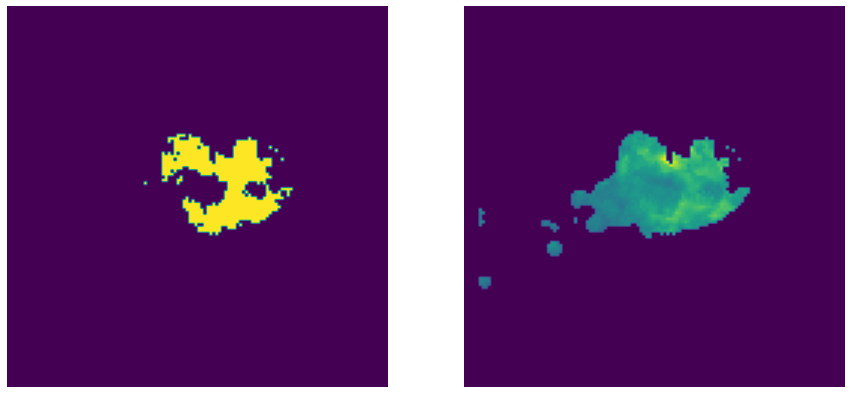

In [125]:
# Plume segmetation
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))

axes = axes.flatten()
list(map(lambda x: x.set_axis_off(), axes))
axes[0].imshow(np.logical_and(data[80652] >=2500, data[80652] < 5000))
axes[1].imshow(data[80652])
plt.show()

Note: Plume is a blob of very hot gas can be even hotter than the centre of the melt pool (as shown in the viz above).Spatter particles are usually colder(hence not segmented), this makes sense too as energy density reduces due to spattering effects.

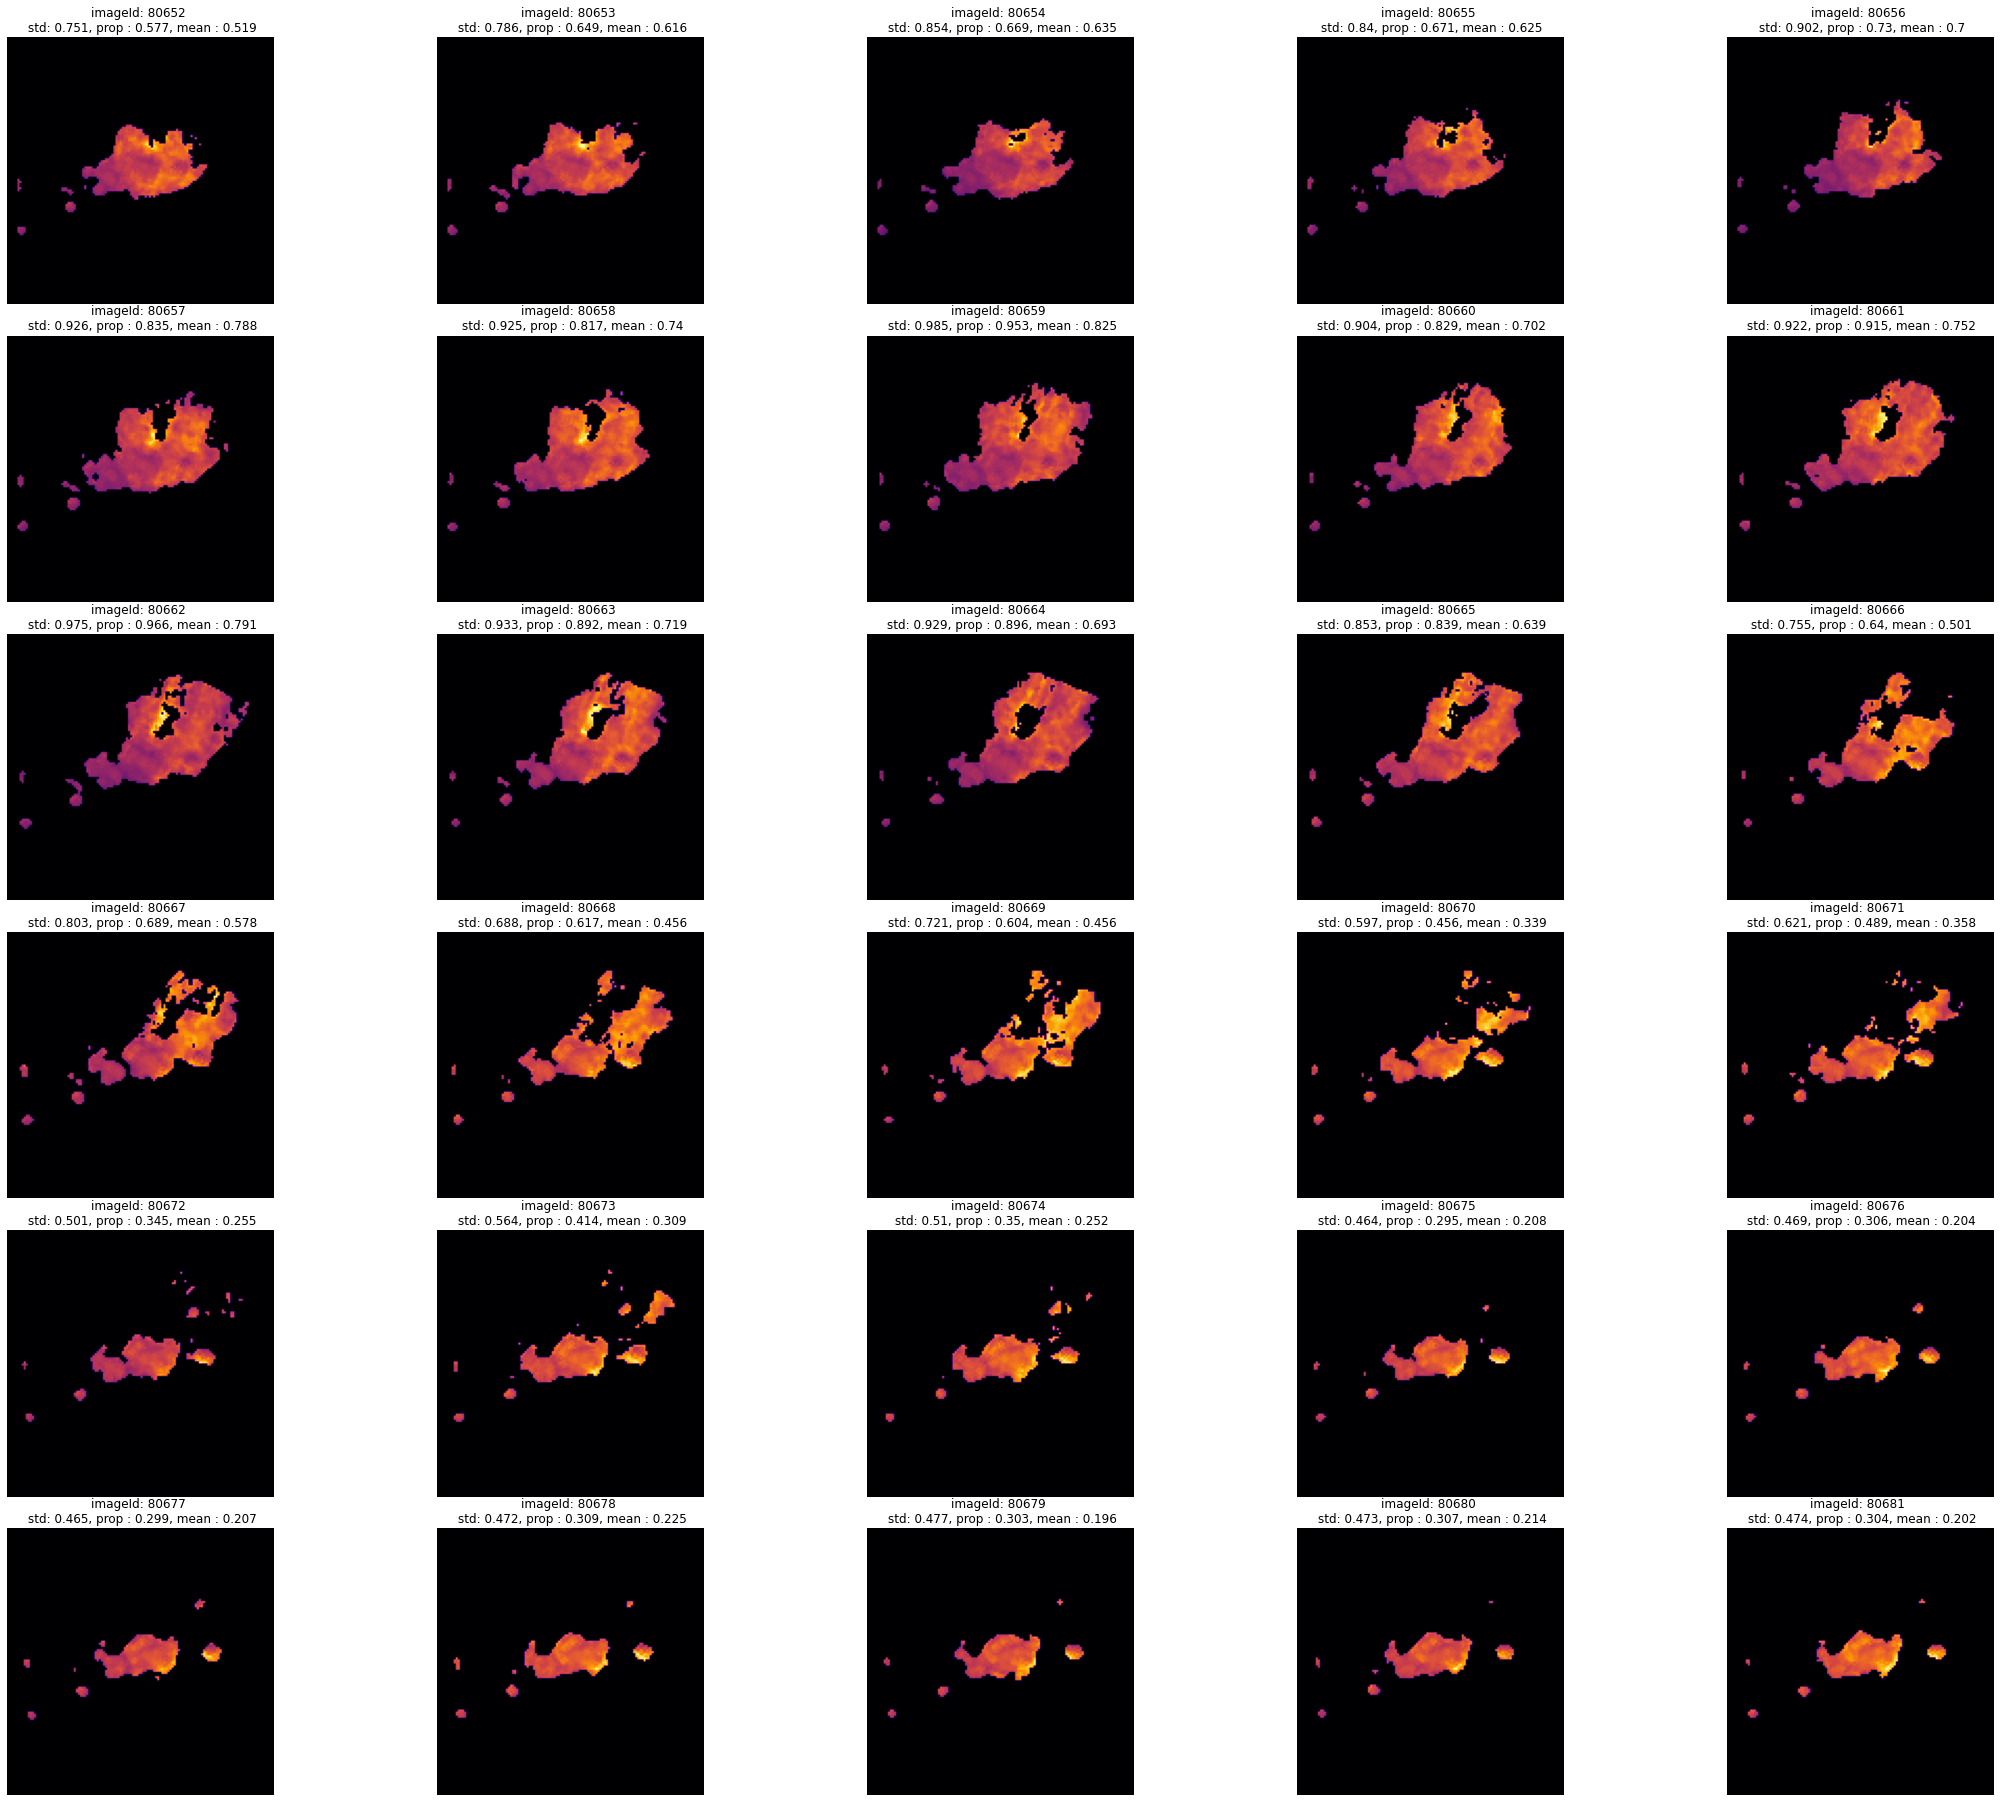

In [126]:
# Take a look at the frames near to 80652
# print out every jump=1(subsequent) frame

disp_images(index = 80652, n = 30, jump=1)